In [1]:
import urllib, json, objectpath
from pprint import pprint

In [2]:
def get_data(route):
    response = urllib.urlopen('http://pendlr.risc-software.at/log?id=["%s"]&num=10000' % route)
    data = json.loads(response.read())
    tree_obj = objectpath.Tree(data)
    return tuple(tree_obj.execute('$..entries'))
def get_route():
    response = urllib.urlopen('http://pendlr.risc-software.at/log?num=10000')
    data = json.loads(response.read())
    tree_obj = objectpath.Tree(data)
    return tuple(tree_obj.execute('$..id'))

In [3]:
routes = get_route()
cur_data   = {}

for r in routes :
    if 'cur.' in r:
        print "-- route : ", r
        cur_data[r] = get_data(r)

-- route :  cur.einwaerts.haselgraben.traffic.risc-software.at
-- route :  cur.wilhering.b129.traffic.risc-software.at
-- route :  cur.zentrum.b129.traffic.risc-software.at
-- route :  cur.rohrbach.b127.traffic.risc-software.at
-- route :  cur.linz.autobahnbruecke.traffic.risc-software.at
-- route :  cur.haid.knotenlinz.traffic.risc-software.at
-- route :  cur.steyregg.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.franzosenhausweg.knotenlinz.traffic.risc-software.at
-- route :  cur.bindermichl.b1.traffic.risc-software.at
-- route :  cur.einwaerts.bindermichl.traffic.risc-software.at
-- route :  cur.linz.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.auswaerts.bindermichl.traffic.risc-software.at
-- route :  cur.florianerstrasse.knotenlinz.traffic.risc-software.at
-- route :  cur.urfahr.nibelungenbruecke.traffic.risc-software.at
-- route :  cur.urfahr.b127.traffic.risc-software.at
-- route :  cur.traun.b1.traffic.risc-software.at
-- route :  cur.auswaerts.haselg

In [4]:
pprint(cur_data['cur.traun.b1.traffic.risc-software.at'][0])

{u'data': {u'attrs': {u'average_speed': 43.2,
                      u'delay': 11,
                      u'delayed_average_speed': 43.2,
                      u'distance': [5043],
                      u'duration': [403],
                      u'duration_in_traffic': [414],
                      u'total_distance': 5043,
                      u'total_duration': 403,
                      u'total_duration_in_traffic': 414},
           u'nip': u'10.32.5.17',
           u'o_id': u'cur.traun.b1.traffic.risc-software.at'},
 u'latency': 30,
 u'ts': 1482327006722}


In [5]:
import pandas as pd 
from pandas.io.json import json_normalize

In [6]:
cur_df = {}
for c in cur_data:
    print '-- route : ', c
    cur_df[c] = json_normalize(cur_data[c])

-- route :  cur.wilhering.b129.traffic.risc-software.at
-- route :  cur.steyregg.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.haid.knotenlinz.traffic.risc-software.at
-- route :  cur.bindermichl.b1.traffic.risc-software.at
-- route :  cur.urfahr.autobahnbruecke.traffic.risc-software.at
-- route :  cur.linz.autobahnbruecke.traffic.risc-software.at
-- route :  cur.urfahr.nibelungenbruecke.traffic.risc-software.at
-- route :  cur.urfahr.b127.traffic.risc-software.at
-- route :  cur.rohrbach.b127.traffic.risc-software.at
-- route :  cur.franzosenhausweg.knotenlinz.traffic.risc-software.at
-- route :  cur.zentrum.b129.traffic.risc-software.at
-- route :  cur.florianerstrasse.knotenlinz.traffic.risc-software.at
-- route :  cur.zentrum.nibelungenbruecke.traffic.risc-software.at
-- route :  cur.linz.steyreggerbruecke.traffic.risc-software.at
-- route :  cur.einwaerts.haselgraben.traffic.risc-software.at
-- route :  cur.einwaerts.bindermichl.traffic.risc-software.at
-- route :  cu

In [7]:
features = [ x for x in cur_df["cur.traun.b1.traffic.risc-software.at"].columns if 'attrs' in x ]

In [8]:
pprint(features)

['data.attrs.average_speed',
 'data.attrs.delay',
 'data.attrs.delayed_average_speed',
 'data.attrs.distance',
 'data.attrs.duration',
 'data.attrs.duration_in_traffic',
 'data.attrs.total_distance',
 'data.attrs.total_duration',
 'data.attrs.total_duration_in_traffic']


In [9]:
features =  [
 'data.attrs.delay',
 'data.attrs.delayed_average_speed',
 'data.attrs.duration',
 'data.attrs.duration_in_traffic',
 'data.attrs.total_duration',
 'data.attrs.total_duration_in_traffic']

In [10]:
df = pd.DataFrame(cur_df["cur.zentrum.b129.traffic.risc-software.at"], columns = ['ts'] + features)
df.head()

ts  data.attrs.delay  data.attrs.delayed_average_speed  \
0  1482327007281                 8                              39.6   
1  1482327607575                 2                              39.6   
2  1482328207840                 6                              39.6   
3  1482328303432                 4                              39.6   
4  1482328903952                 9                              39.6   

  data.attrs.duration data.attrs.duration_in_traffic  \
0               [359]                          [367]   
1               [359]                          [361]   
2               [359]                          [365]   
3               [359]                          [363]   
4               [359]                          [368]   

   data.attrs.total_duration  data.attrs.total_duration_in_traffic  
0                        359                                   367  
1                        359                                   361  
2                        359                                   365  
3                        359                                   363  
4                        359                                   368

In [11]:
df['date'] = pd.to_datetime(df['ts']/1000.0, unit='s')

In [14]:
import time
from dateutil import parser, rrule
from datetime import datetime, time, date

df['day'        ] = df['date'].apply(lambda x: x.date())
df['time_of_day'] = df['date'].apply(lambda x: x.time())
df['day_of_week'] = df['date'].apply(lambda x: x.weekday())    
df['hour_of_day'] = df['time_of_day'].apply(lambda x: x.hour)
# Is each time stamp on a working day (Mon-Fri)
df['working_day'] = (df['day_of_week'] >= 0) & (df['day_of_week'] <= 4)
 
# Classify into morning or evening times (assuming travel between 8.15-9am and 5.15-6pm)
df['morning'] = (df['time_of_day'] >= time( 8,15)) & (df['time_of_day'] <= time( 9,0))
df['evening'] = (df['time_of_day'] >= time(17,15)) & (df['time_of_day'] <= time(18,0))

In [20]:
import calmap

# temp = df['data.attrs.delay'].copy().set_index(pd.DatetimeIndex(df['data.attrs.delay']))
#temp.set_index('date', inplace=True)
fig, ax = calmap.calendarplot(df['data.attrs.delay'], fig_kws={"figsize":(15,4)})
plt.title("Hours raining")
# fig, ax = calmap.calendarplot(temp['total_rain'], fig_kws={"figsize":(15,4)})
# plt.title("Total Rainfall Daily")

AttributeError: 'RangeIndex' object has no attribute 'year'

In [12]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
from matplotlib import dates

%matplotlib inline
plt.style.use('muted')

In [13]:
for c in cur_data:
    cur_df[c]['date'] = pd.to_datetime(cur_df[c]['ts']/1000.0, unit='s')

--  data.attrs.delay   cur.wilhering.b129.traffic.risc-software.at


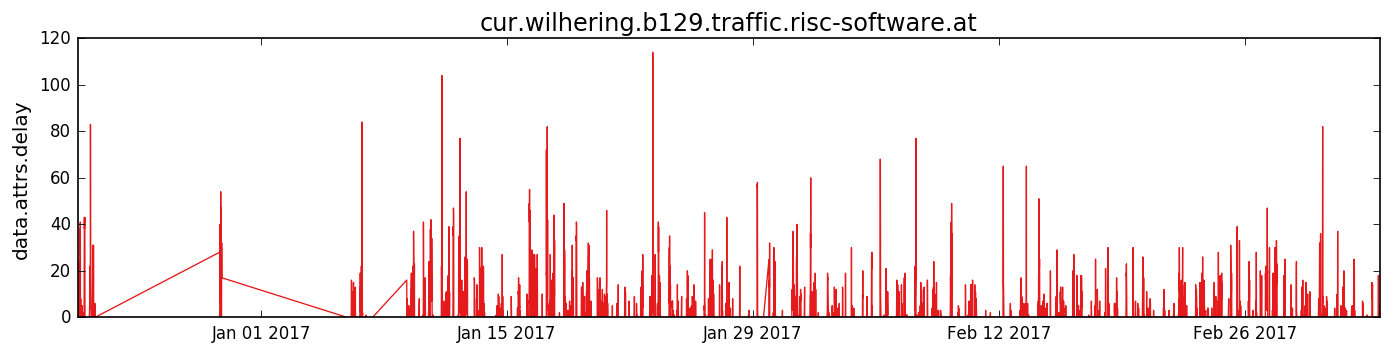

--  data.attrs.delay   cur.auswaerts.bindermichl.traffic.risc-software.at


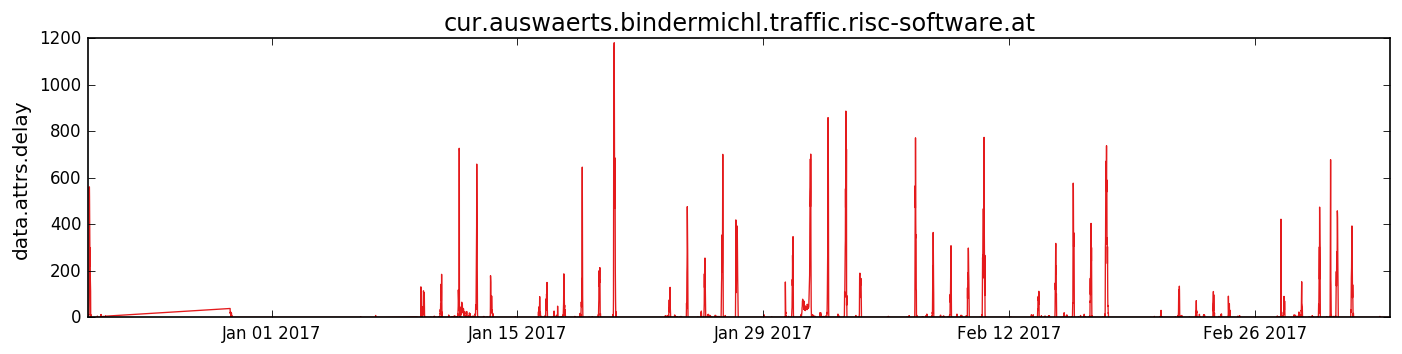

--  data.attrs.delay   cur.steyregg.steyreggerbruecke.traffic.risc-software.at


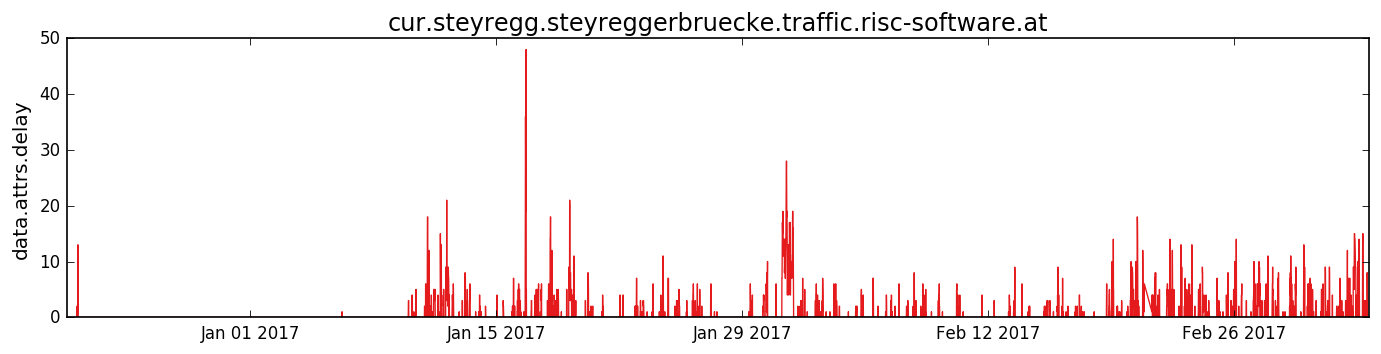

--  data.attrs.delay   cur.haid.knotenlinz.traffic.risc-software.at


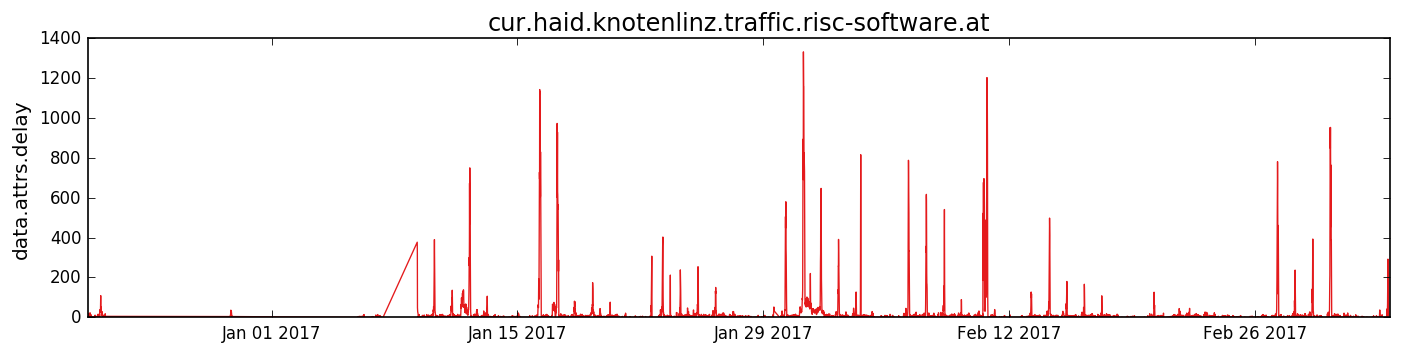

--  data.attrs.delay   cur.bindermichl.b1.traffic.risc-software.at


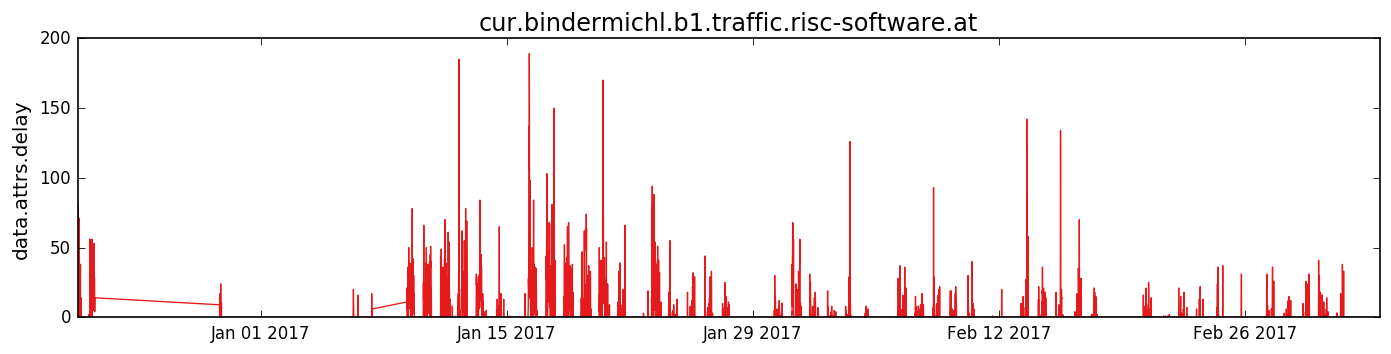

--  data.attrs.delay   cur.urfahr.autobahnbruecke.traffic.risc-software.at


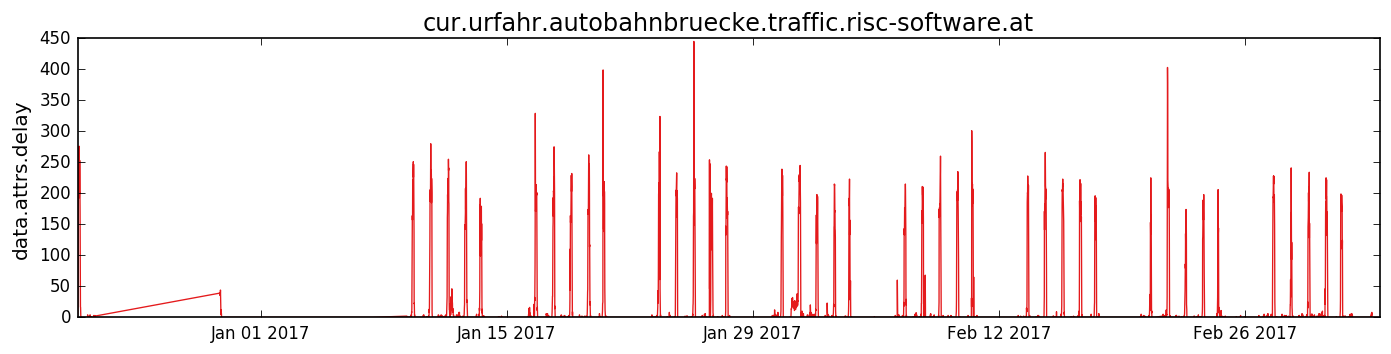

--  data.attrs.delay   cur.linz.autobahnbruecke.traffic.risc-software.at


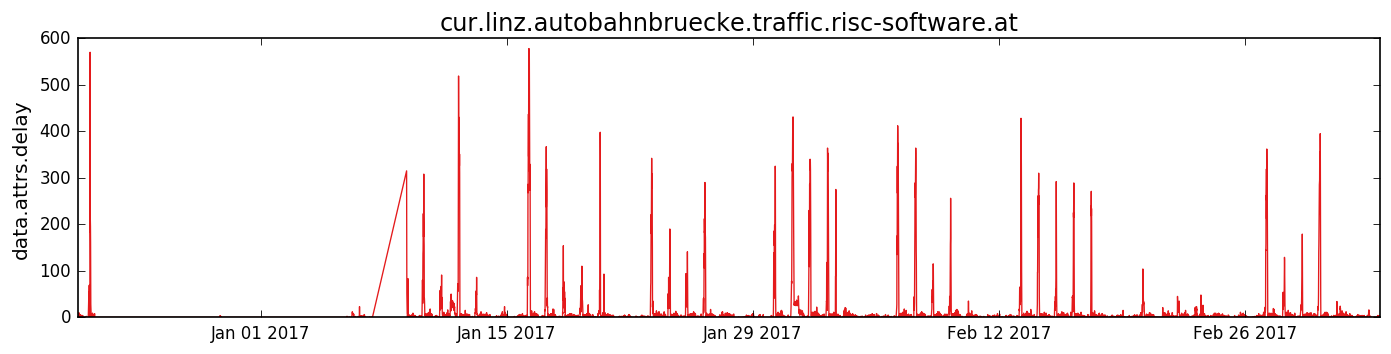

--  data.attrs.delay   cur.urfahr.nibelungenbruecke.traffic.risc-software.at


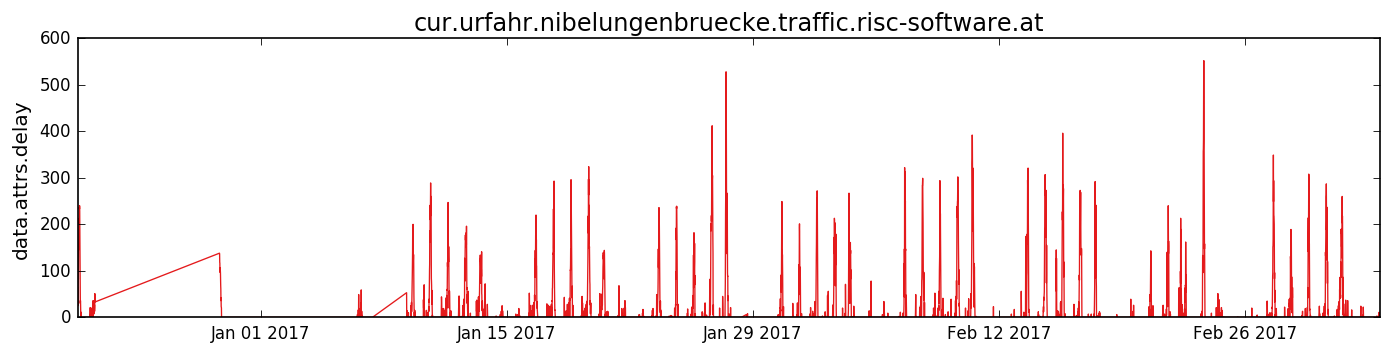

--  data.attrs.delay   cur.urfahr.b127.traffic.risc-software.at


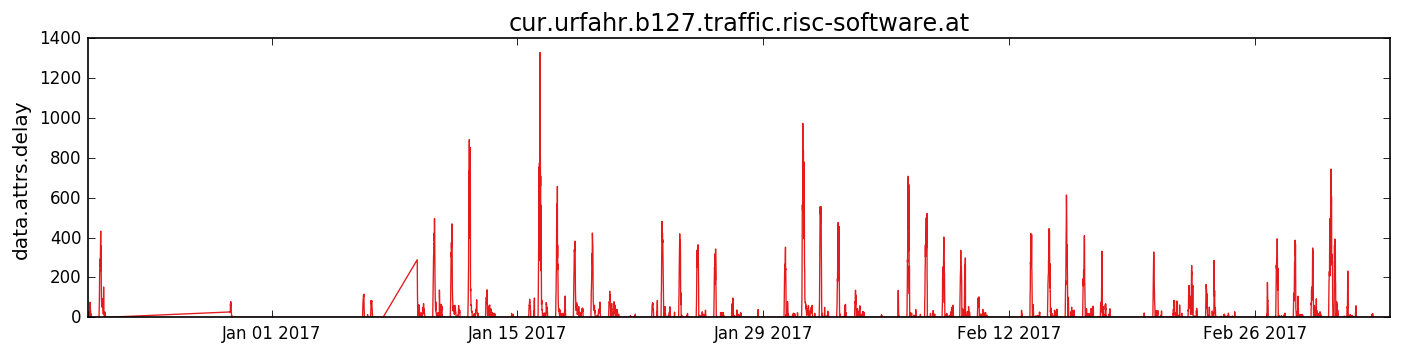

--  data.attrs.delay   cur.rohrbach.b127.traffic.risc-software.at


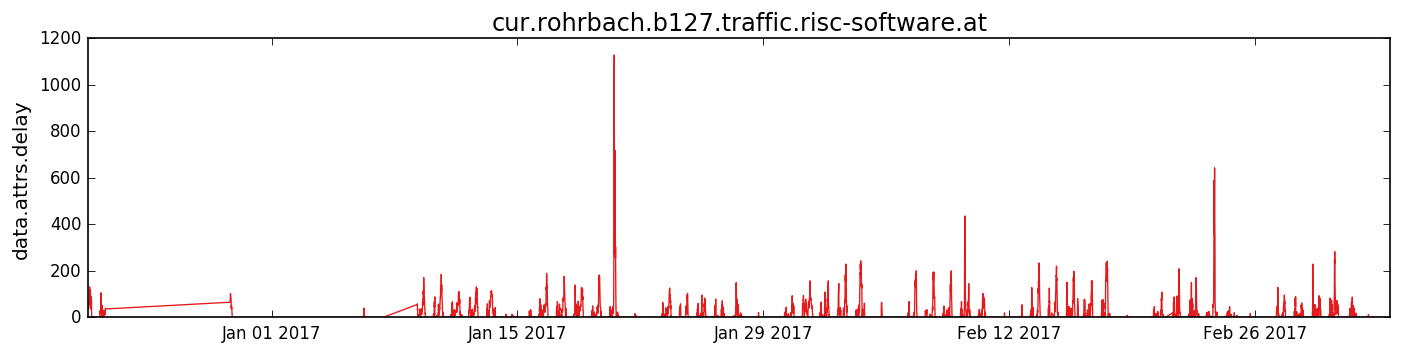

--  data.attrs.delay   cur.franzosenhausweg.knotenlinz.traffic.risc-software.at


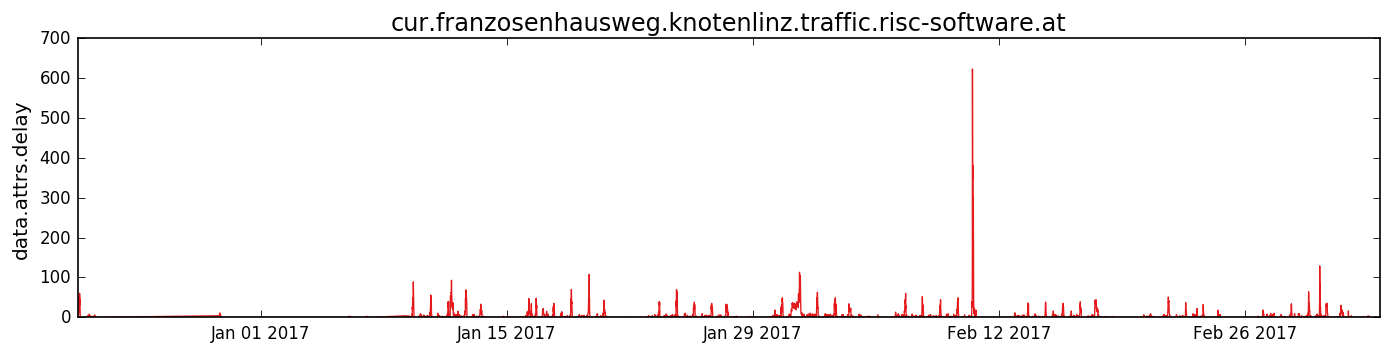

--  data.attrs.delay   cur.zentrum.b129.traffic.risc-software.at


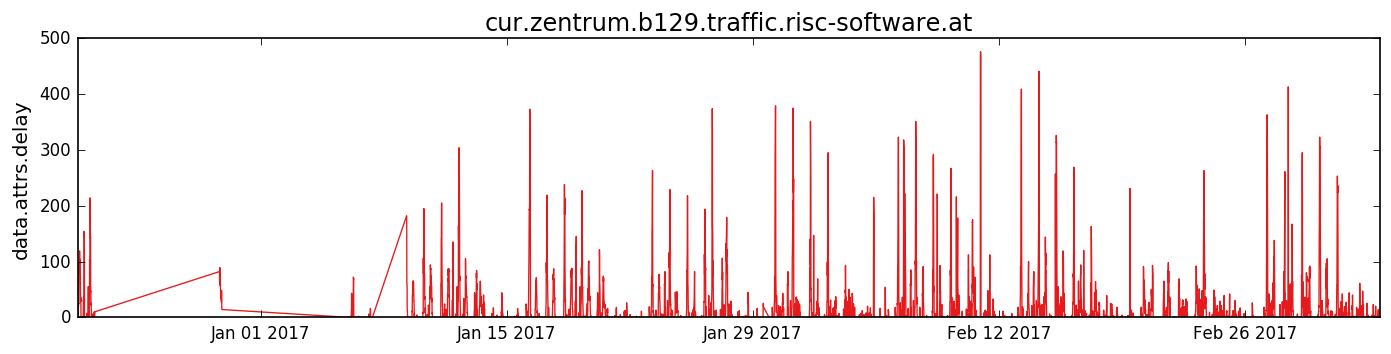

--  data.attrs.delay   cur.florianerstrasse.knotenlinz.traffic.risc-software.at


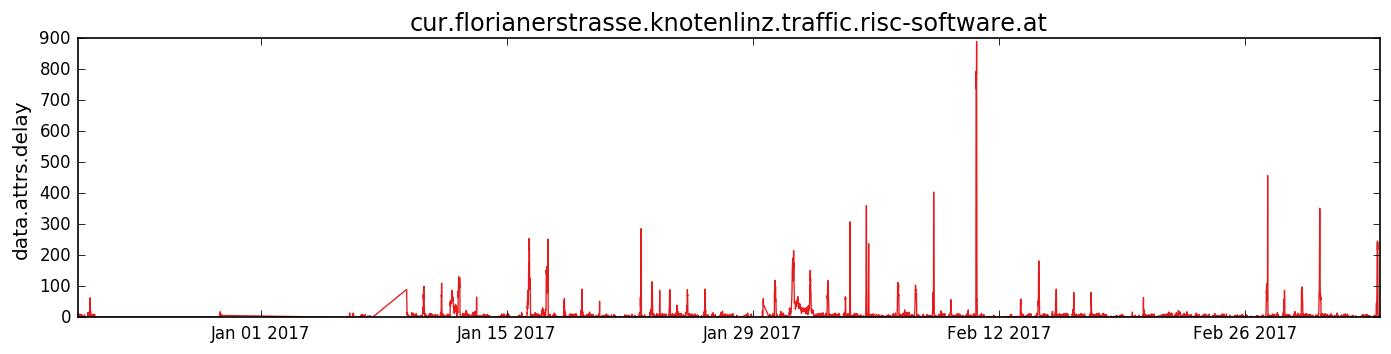

--  data.attrs.delay   cur.linz.steyreggerbruecke.traffic.risc-software.at


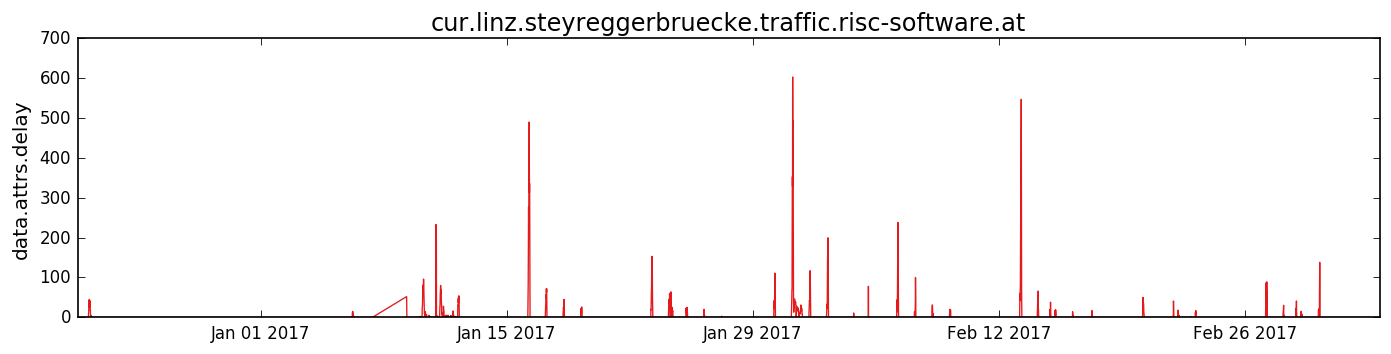

--  data.attrs.delay   cur.zentrum.nibelungenbruecke.traffic.risc-software.at


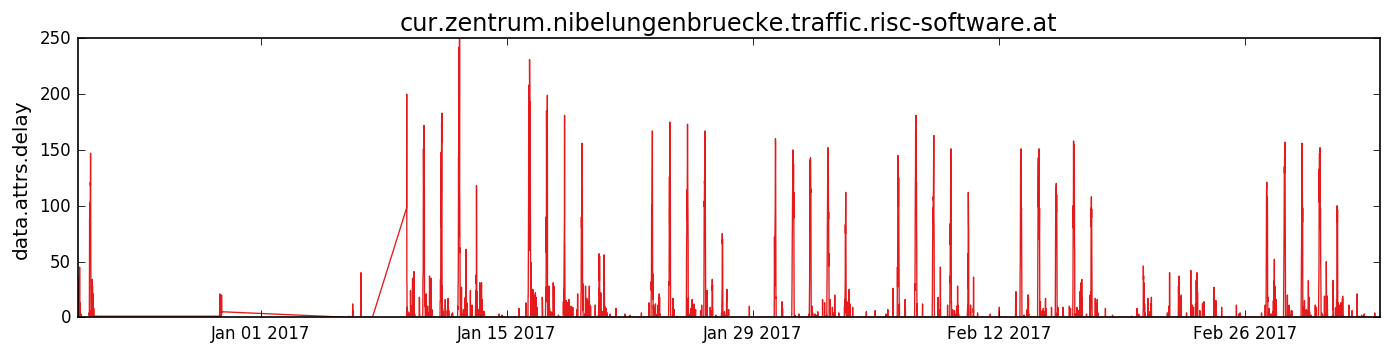

--  data.attrs.delay   cur.einwaerts.bindermichl.traffic.risc-software.at


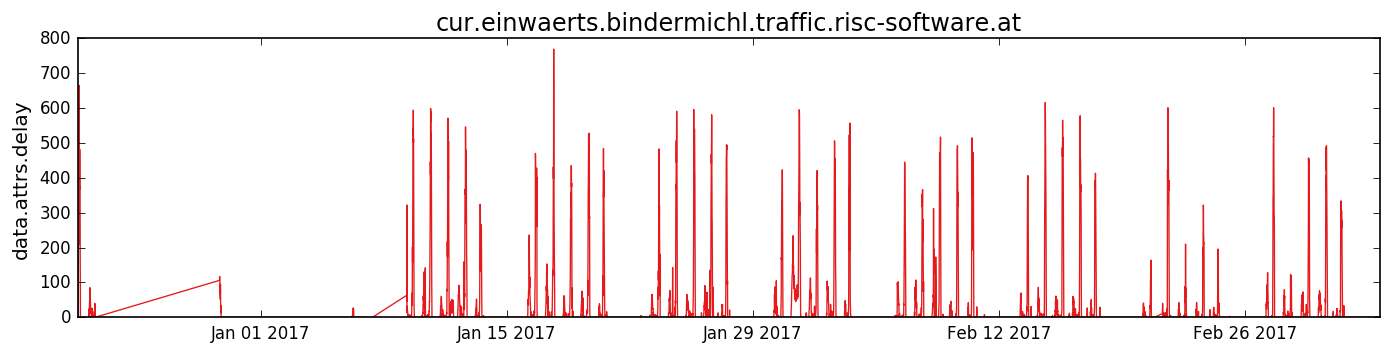

--  data.attrs.delay   cur.traun.b1.traffic.risc-software.at


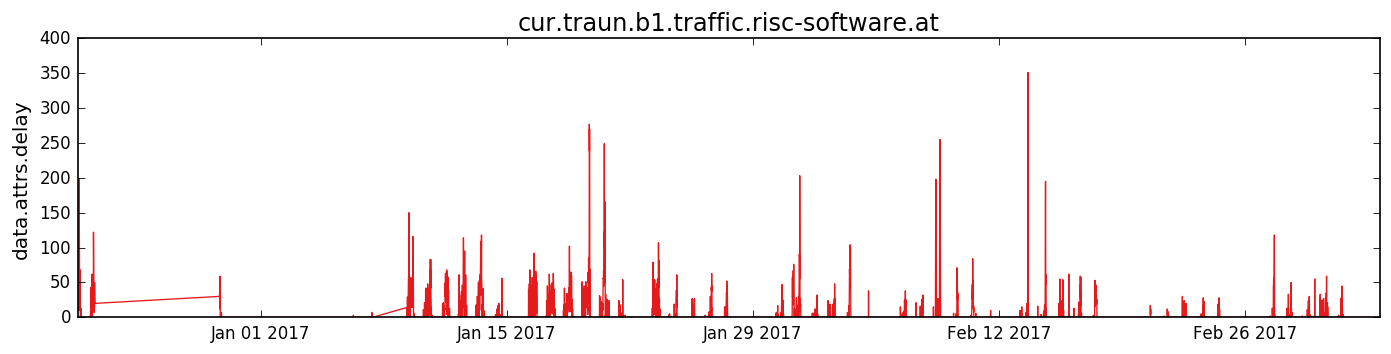

--  data.attrs.delay   cur.auswaerts.haselgraben.traffic.risc-software.at


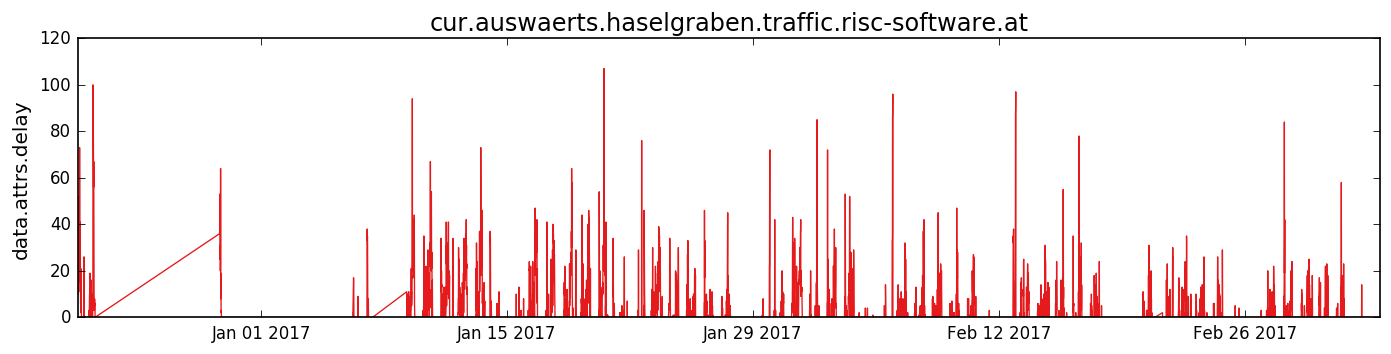

--  data.attrs.delay   cur.einwaerts.haselgraben.traffic.risc-software.at


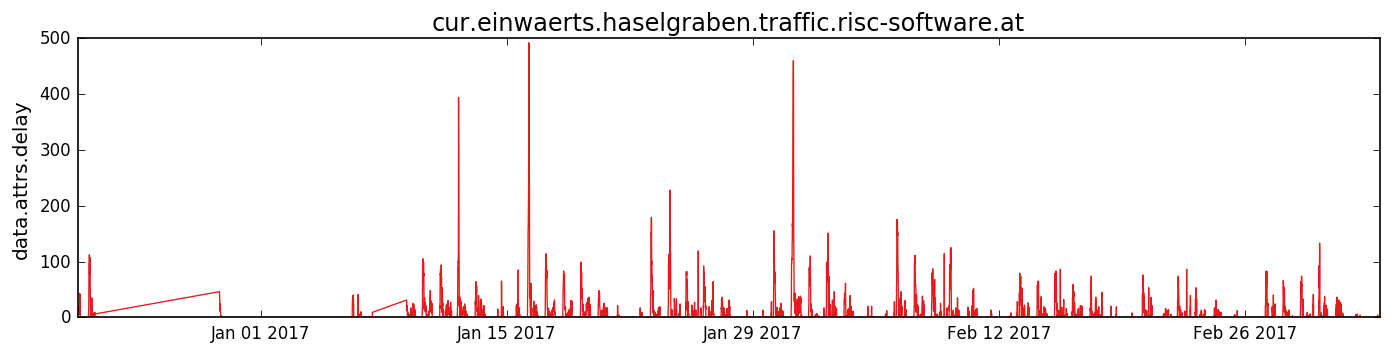

--  data.attrs.delayed_average_speed   cur.wilhering.b129.traffic.risc-software.at


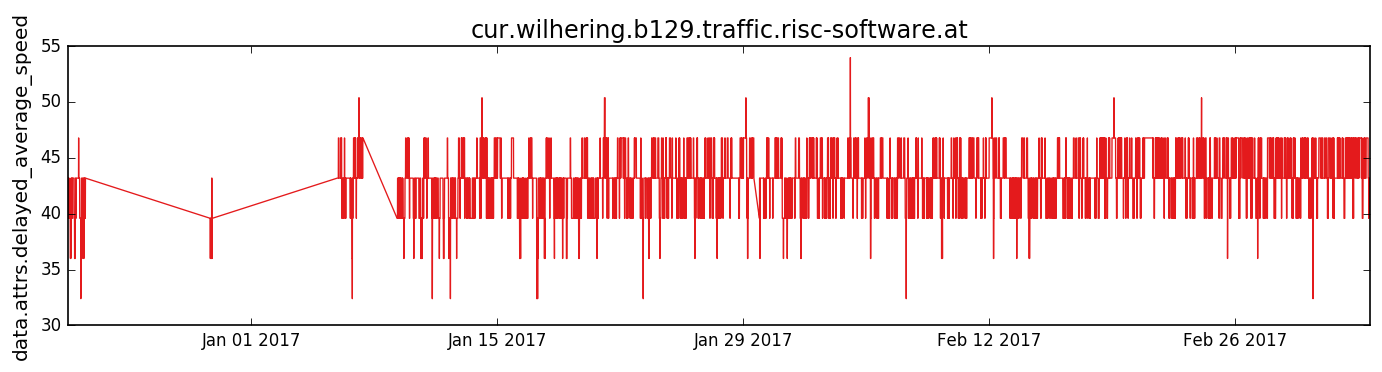

--  data.attrs.delayed_average_speed   cur.auswaerts.bindermichl.traffic.risc-software.at


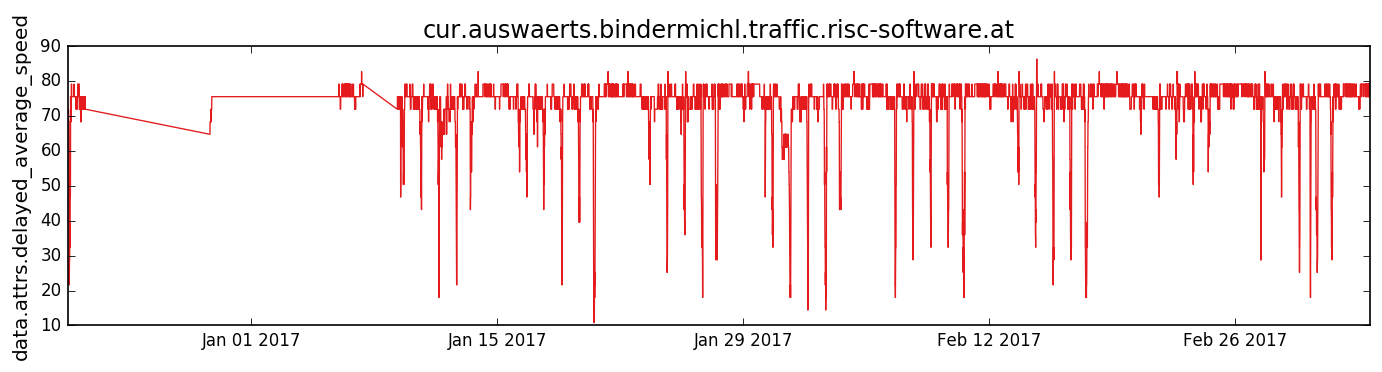

--  data.attrs.delayed_average_speed   cur.steyregg.steyreggerbruecke.traffic.risc-software.at


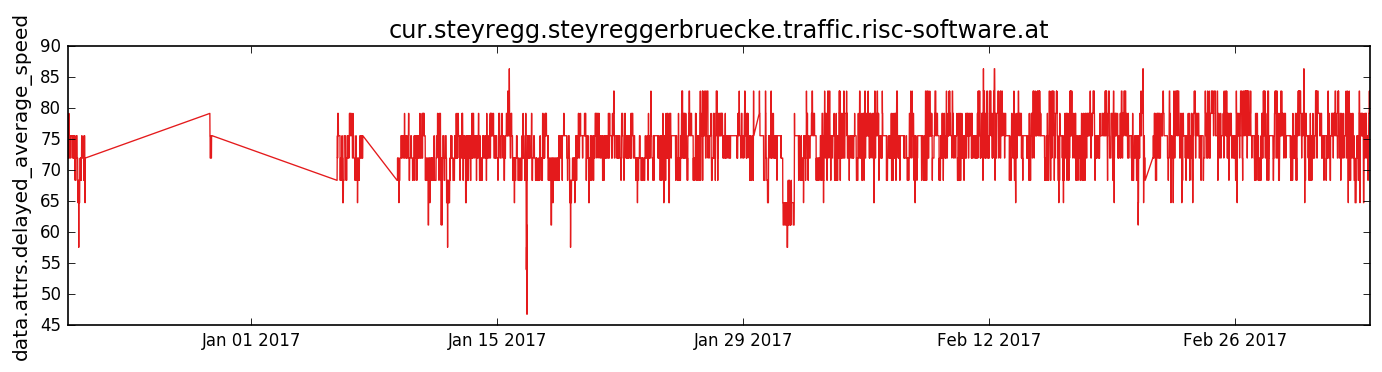

--  data.attrs.delayed_average_speed   cur.haid.knotenlinz.traffic.risc-software.at


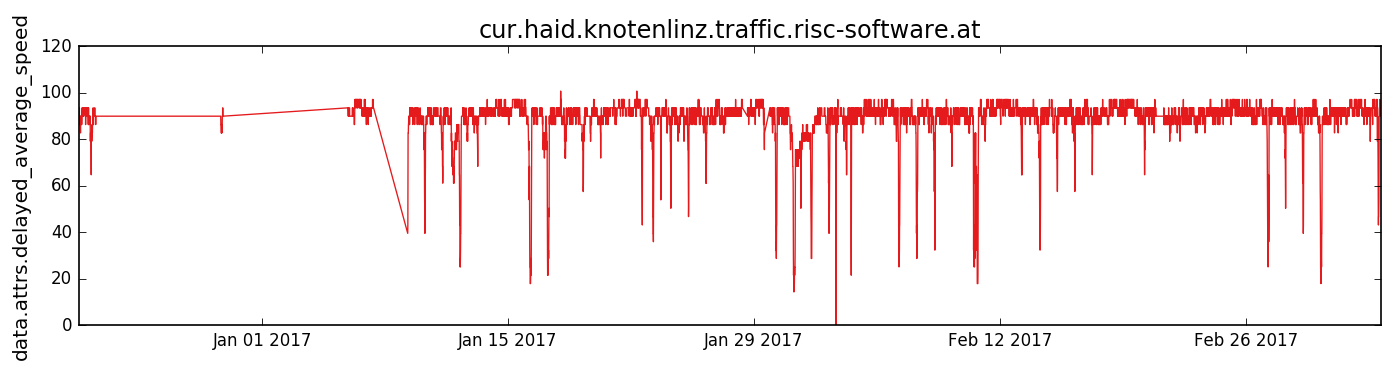

--  data.attrs.delayed_average_speed   cur.bindermichl.b1.traffic.risc-software.at


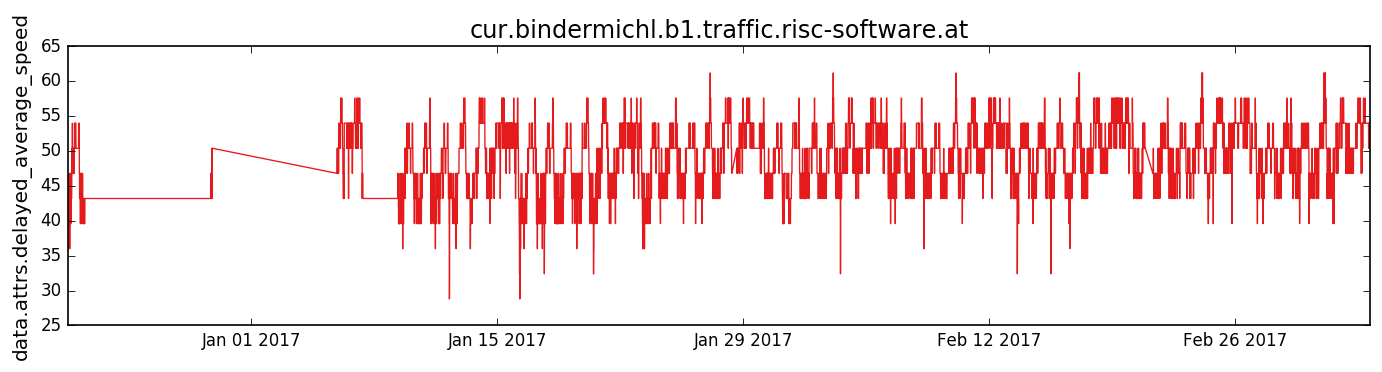

--  data.attrs.delayed_average_speed   cur.urfahr.autobahnbruecke.traffic.risc-software.at


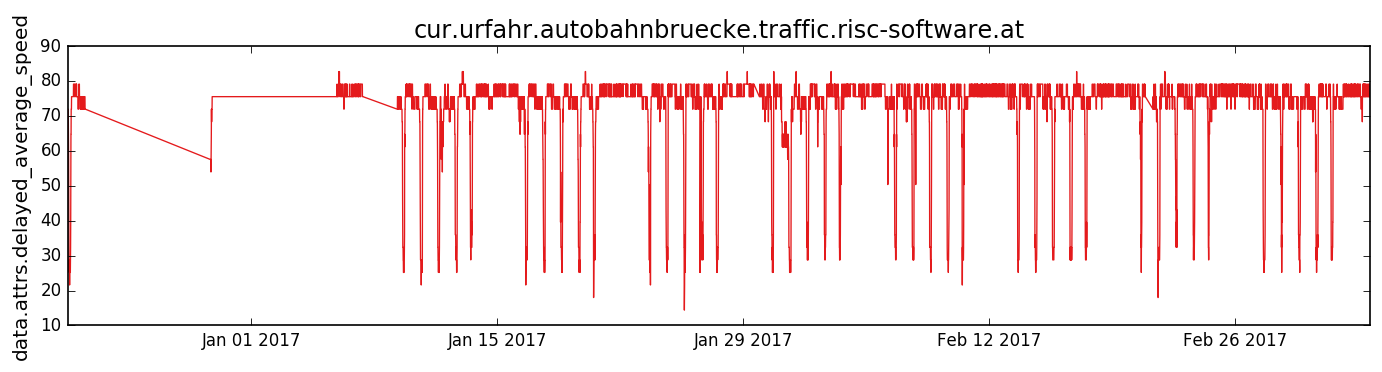

--  data.attrs.delayed_average_speed   cur.linz.autobahnbruecke.traffic.risc-software.at


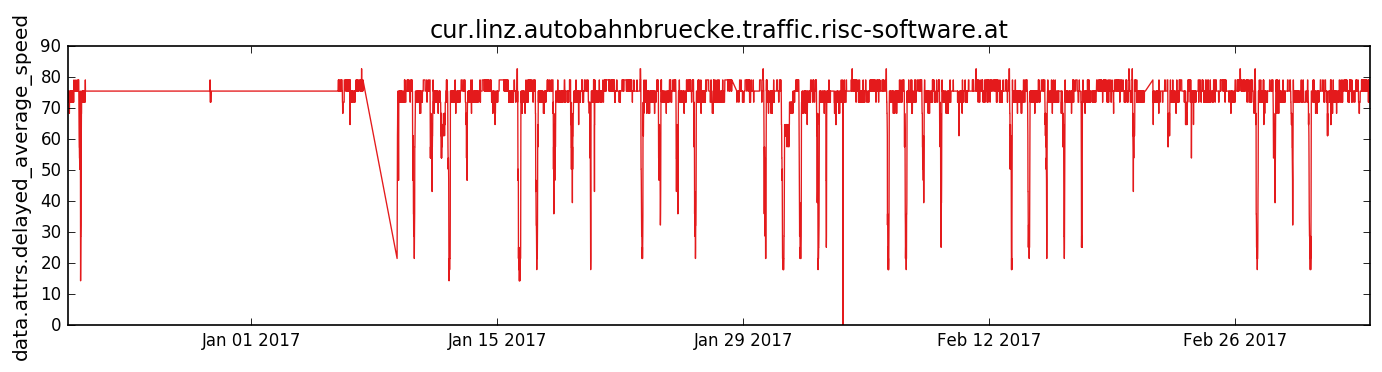

--  data.attrs.delayed_average_speed   cur.urfahr.nibelungenbruecke.traffic.risc-software.at


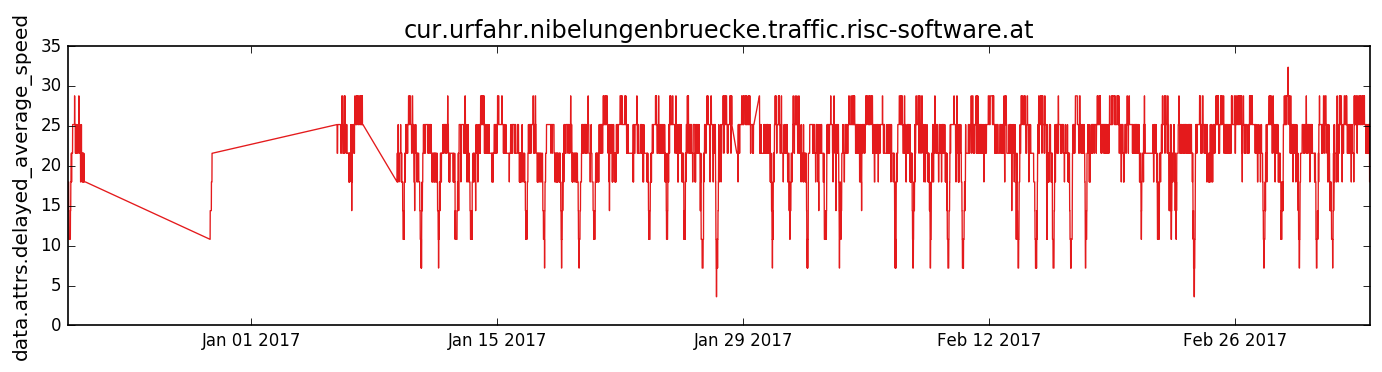

--  data.attrs.delayed_average_speed   cur.urfahr.b127.traffic.risc-software.at


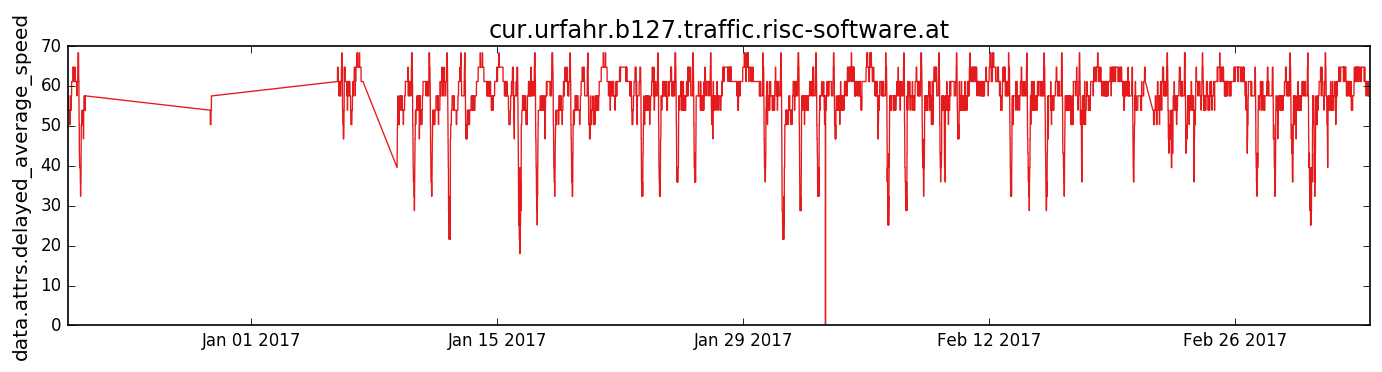

--  data.attrs.delayed_average_speed   cur.rohrbach.b127.traffic.risc-software.at


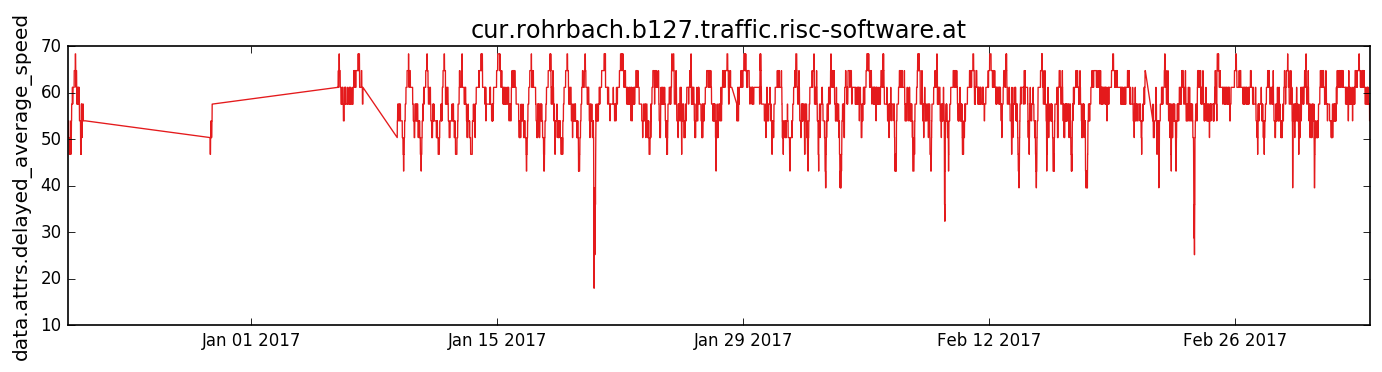

--  data.attrs.delayed_average_speed   cur.franzosenhausweg.knotenlinz.traffic.risc-software.at


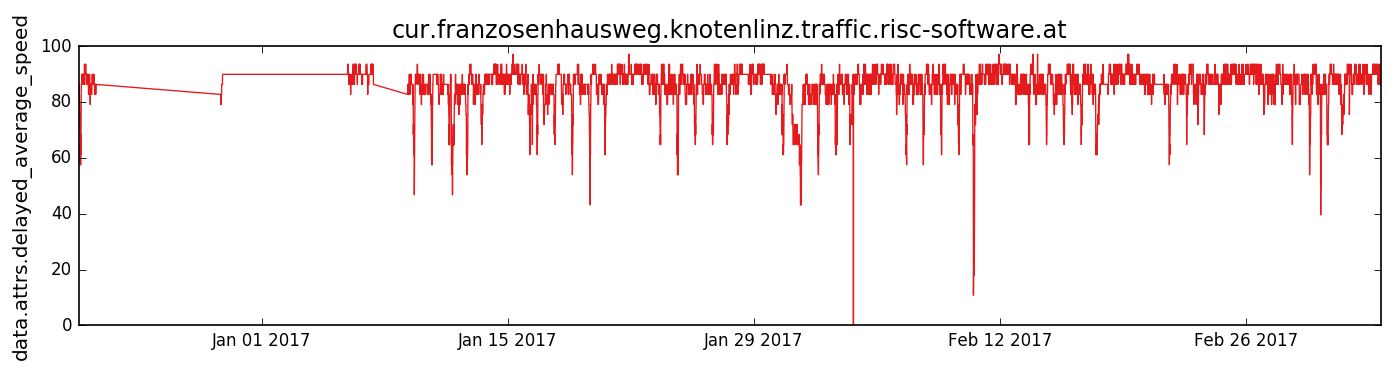

--  data.attrs.delayed_average_speed   cur.zentrum.b129.traffic.risc-software.at


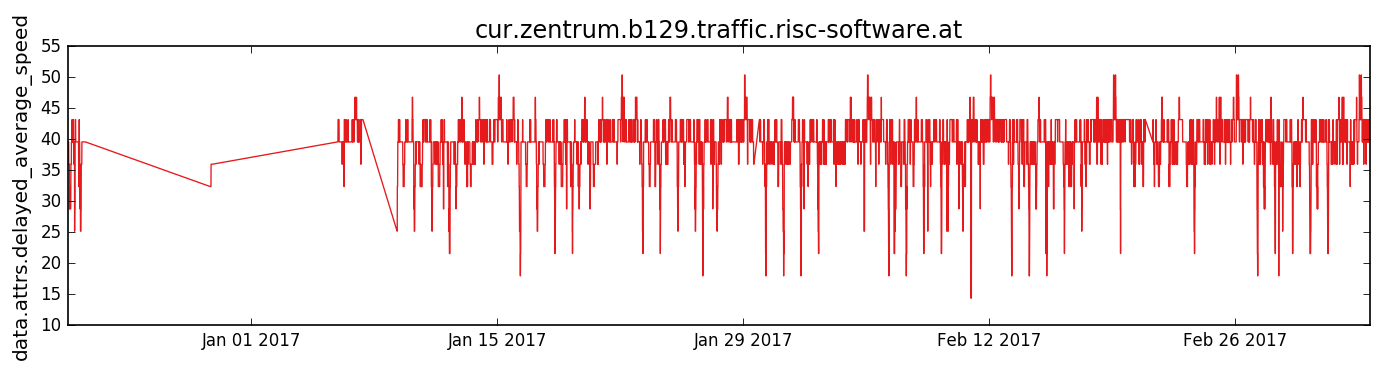

--  data.attrs.delayed_average_speed   cur.florianerstrasse.knotenlinz.traffic.risc-software.at


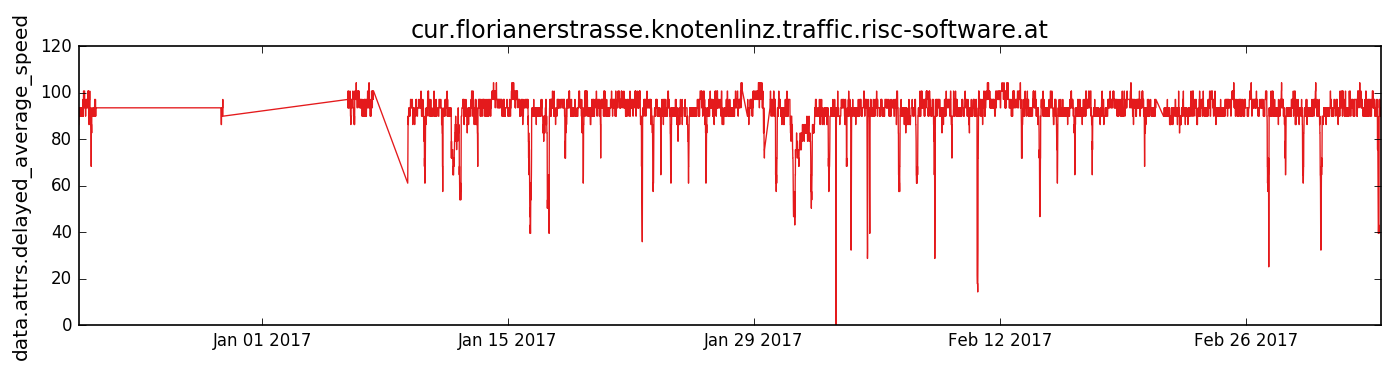

--  data.attrs.delayed_average_speed   cur.linz.steyreggerbruecke.traffic.risc-software.at


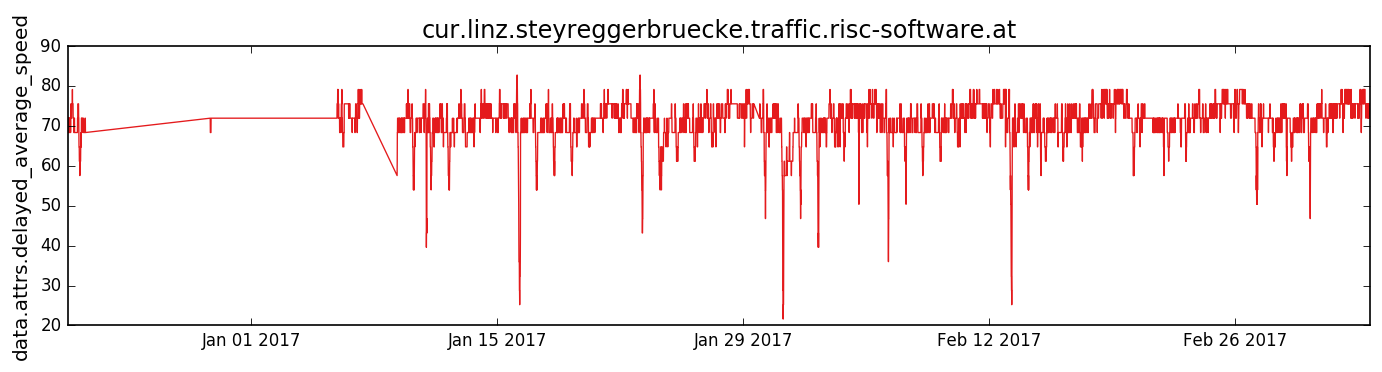

--  data.attrs.delayed_average_speed   cur.zentrum.nibelungenbruecke.traffic.risc-software.at


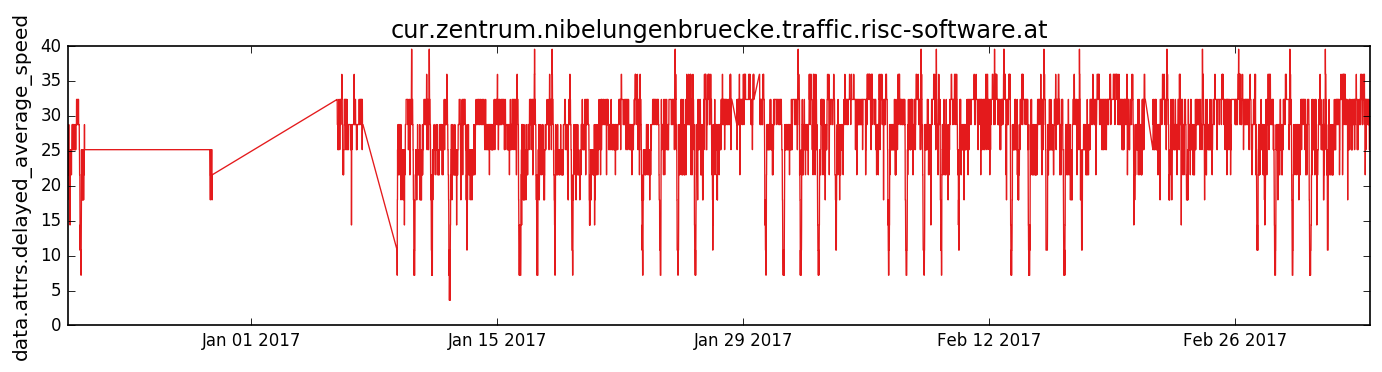

--  data.attrs.delayed_average_speed   cur.einwaerts.bindermichl.traffic.risc-software.at


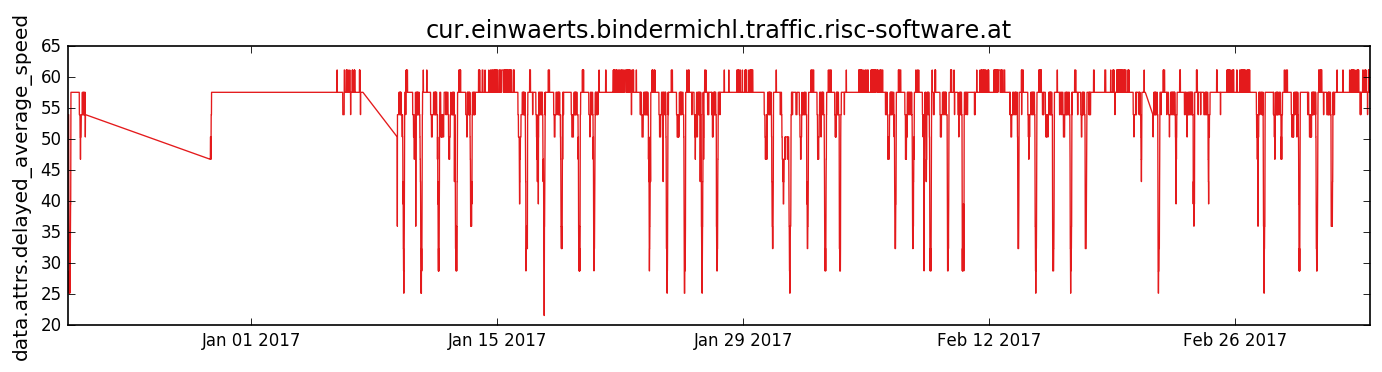

--  data.attrs.delayed_average_speed   cur.traun.b1.traffic.risc-software.at


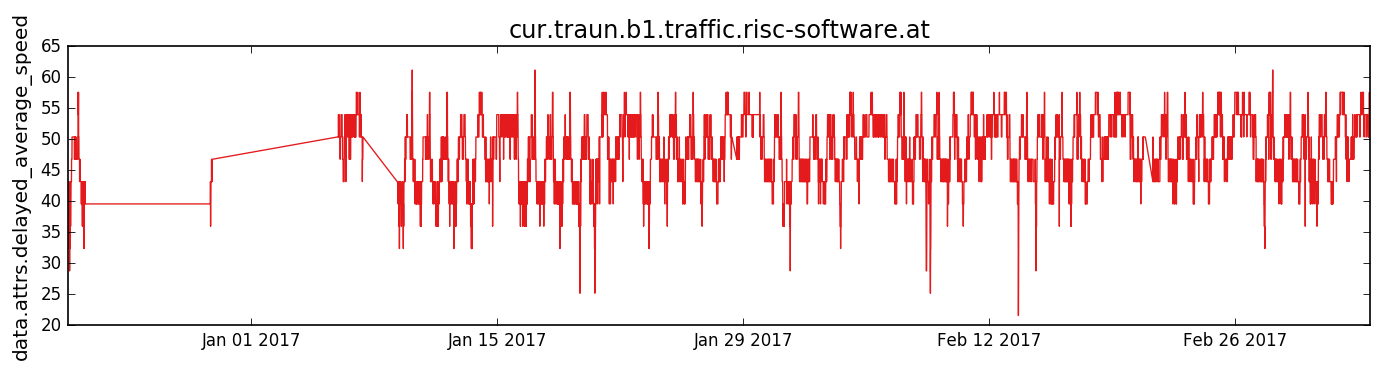

--  data.attrs.delayed_average_speed   cur.auswaerts.haselgraben.traffic.risc-software.at


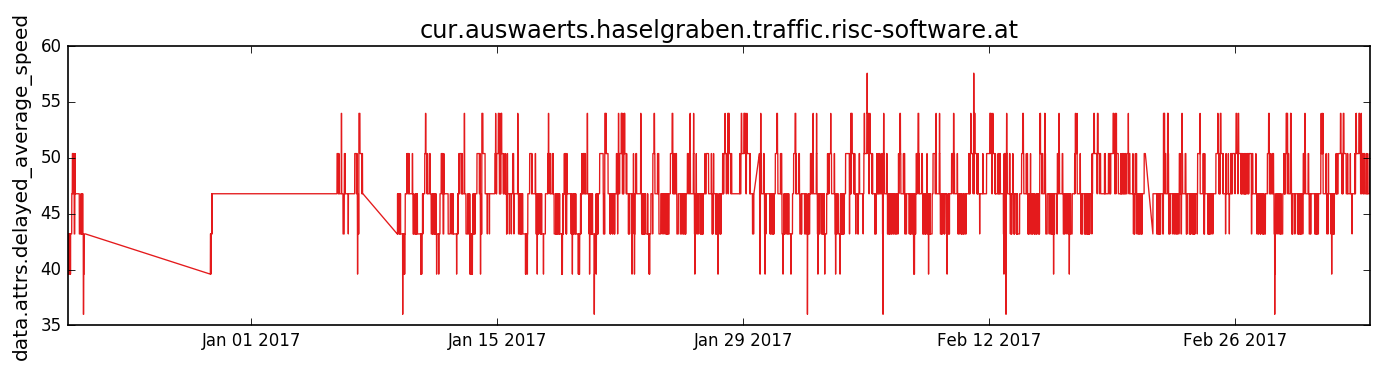

--  data.attrs.delayed_average_speed   cur.einwaerts.haselgraben.traffic.risc-software.at


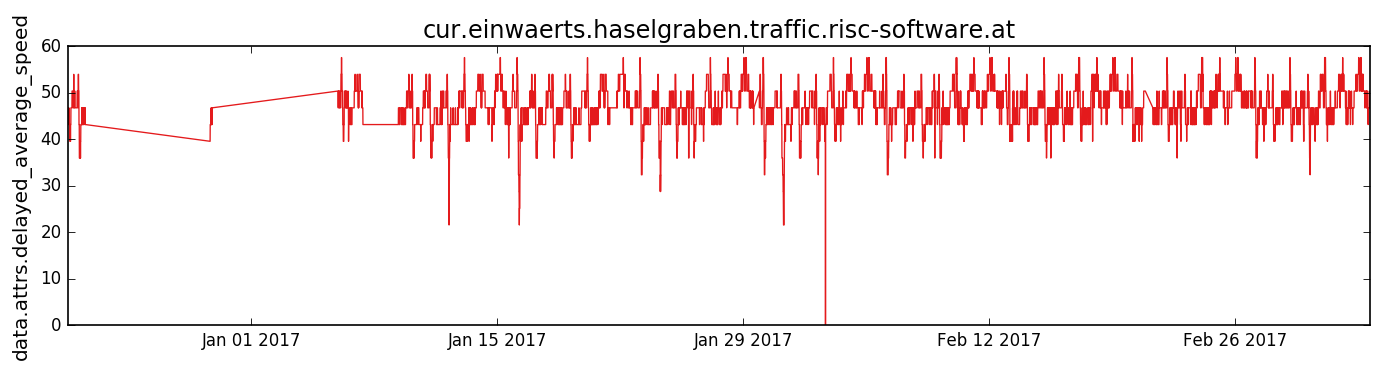

--  data.attrs.duration   cur.wilhering.b129.traffic.risc-software.at
--  data.attrs.duration   cur.auswaerts.bindermichl.traffic.risc-software.at
--  data.attrs.duration   cur.steyregg.steyreggerbruecke.traffic.risc-software.at
--  data.attrs.duration   cur.haid.knotenlinz.traffic.risc-software.at
--  data.attrs.duration   cur.bindermichl.b1.traffic.risc-software.at
--  data.attrs.duration   cur.urfahr.autobahnbruecke.traffic.risc-software.at
--  data.attrs.duration   cur.linz.autobahnbruecke.traffic.risc-software.at
--  data.attrs.duration   cur.urfahr.nibelungenbruecke.traffic.risc-software.at
--  data.attrs.duration   cur.urfahr.b127.traffic.risc-software.at
--  data.attrs.duration   cur.rohrbach.b127.traffic.risc-software.at
--  data.attrs.duration   cur.franzosenhausweg.knotenlinz.traffic.risc-software.at
--  data.attrs.duration   cur.zentrum.b129.traffic.risc-software.at
--  data.attrs.duration   cur.florianerstrasse.knotenlinz.traffic.risc-software.at
--  data.attrs.duration   

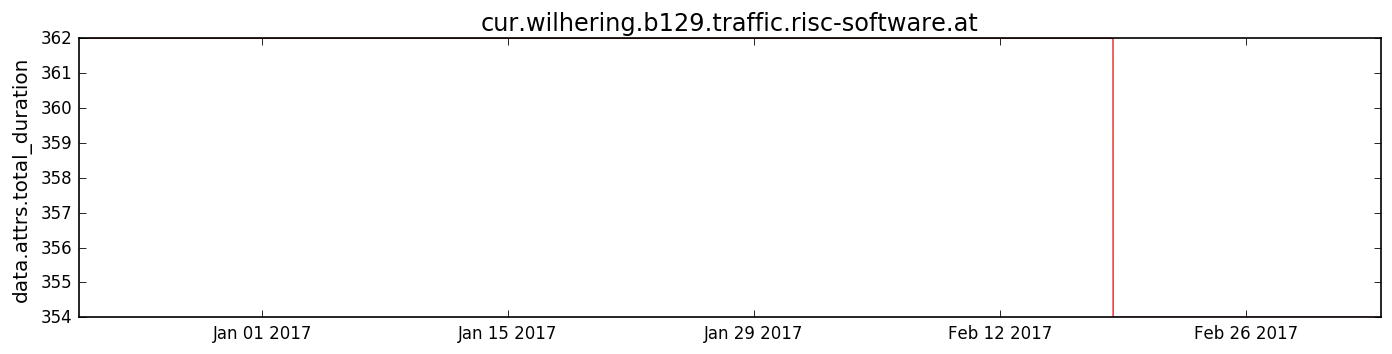

--  data.attrs.total_duration   cur.auswaerts.bindermichl.traffic.risc-software.at


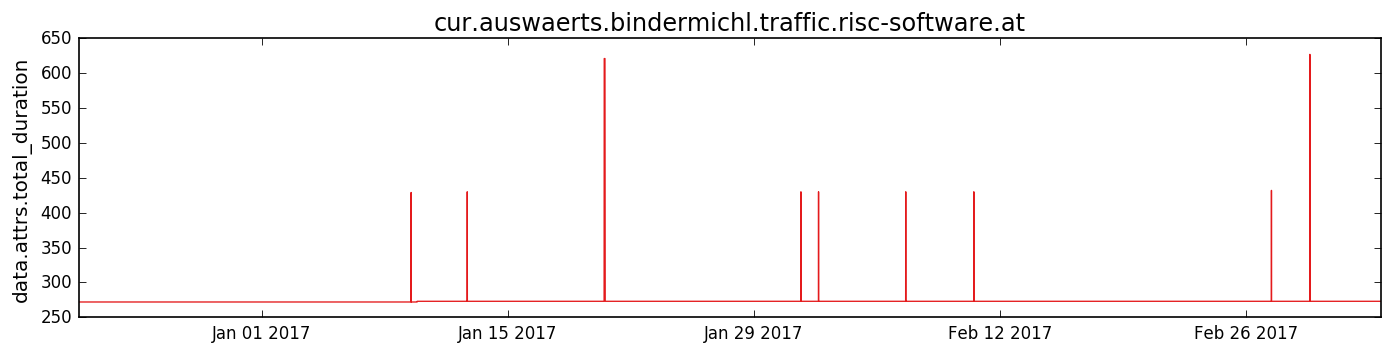

--  data.attrs.total_duration   cur.steyregg.steyreggerbruecke.traffic.risc-software.at


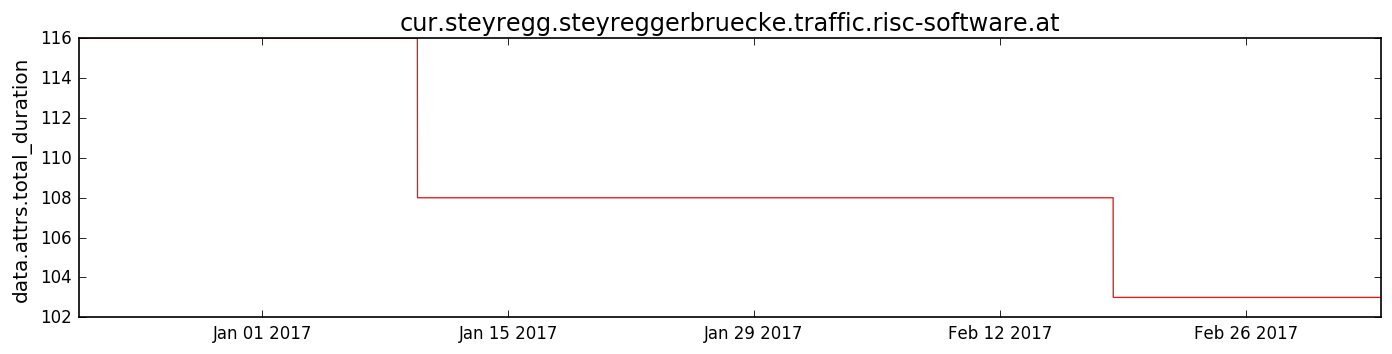

--  data.attrs.total_duration   cur.haid.knotenlinz.traffic.risc-software.at


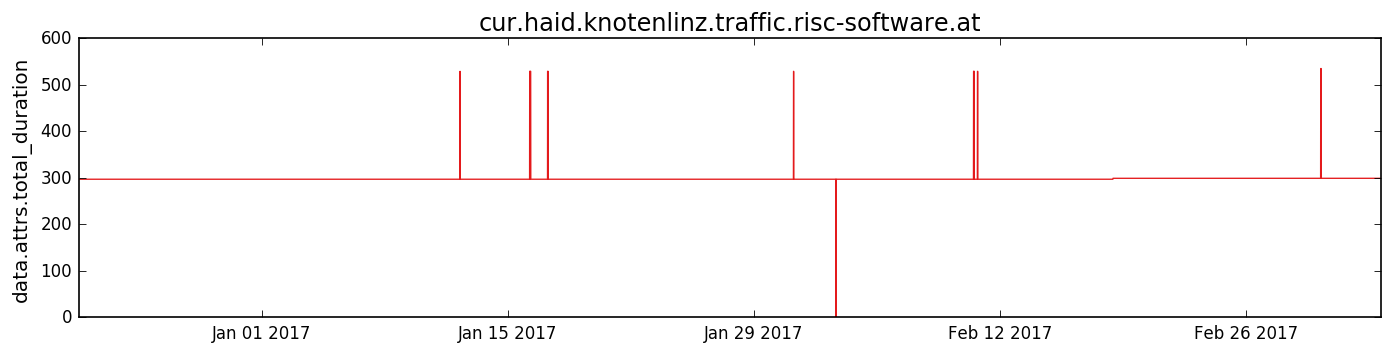

--  data.attrs.total_duration   cur.bindermichl.b1.traffic.risc-software.at


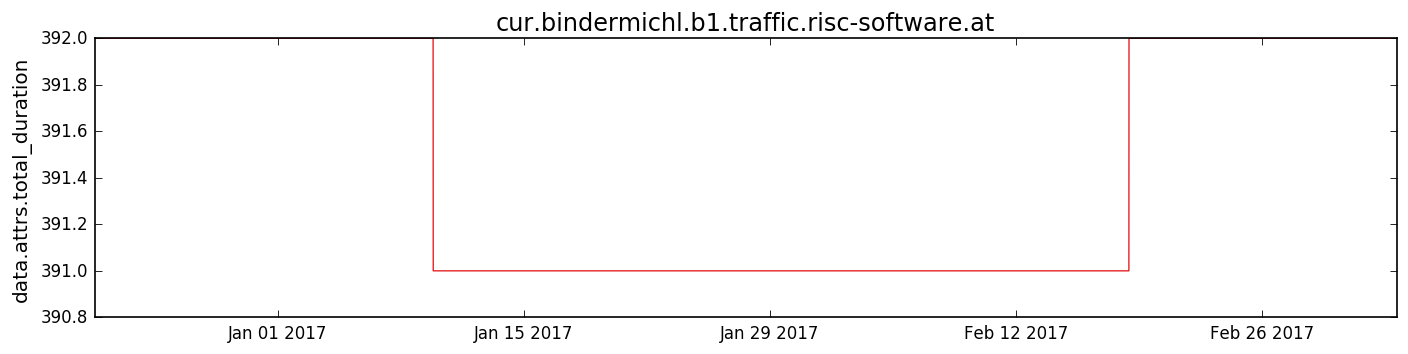

--  data.attrs.total_duration   cur.urfahr.autobahnbruecke.traffic.risc-software.at


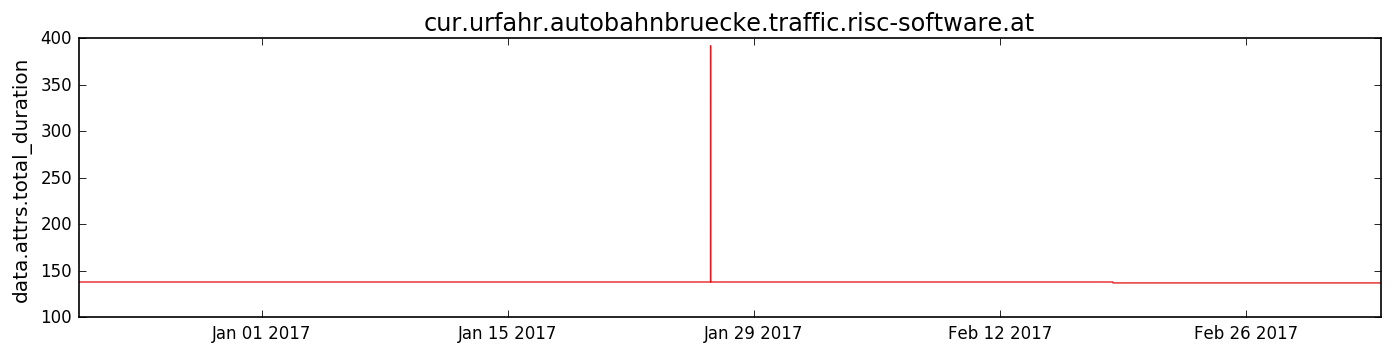

--  data.attrs.total_duration   cur.linz.autobahnbruecke.traffic.risc-software.at


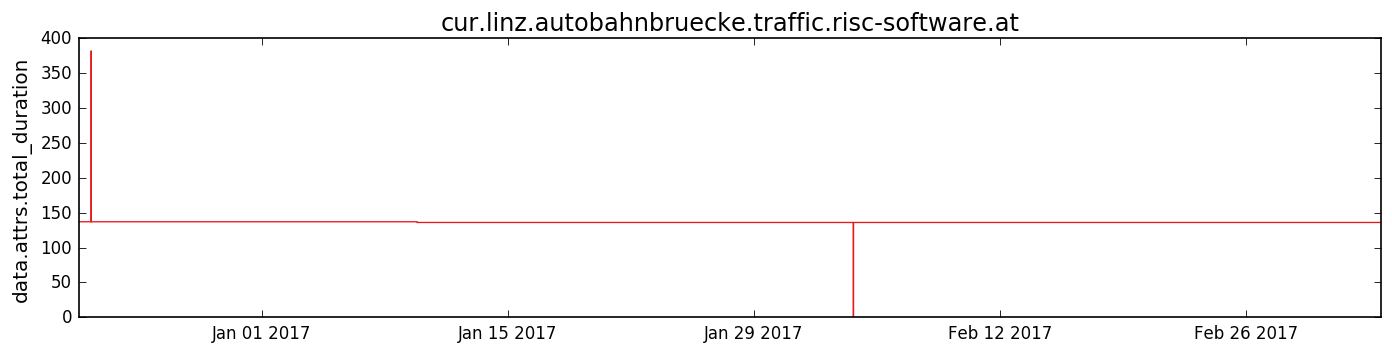

--  data.attrs.total_duration   cur.urfahr.nibelungenbruecke.traffic.risc-software.at


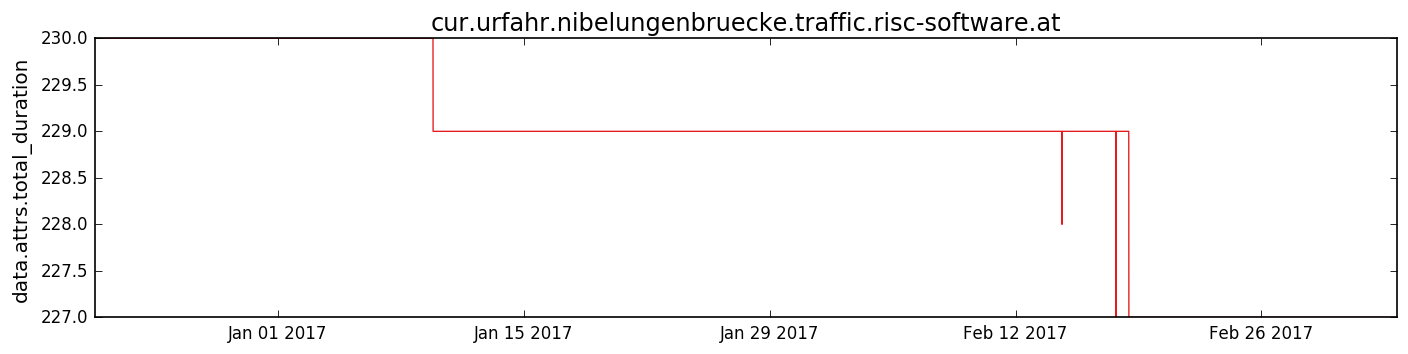

--  data.attrs.total_duration   cur.urfahr.b127.traffic.risc-software.at


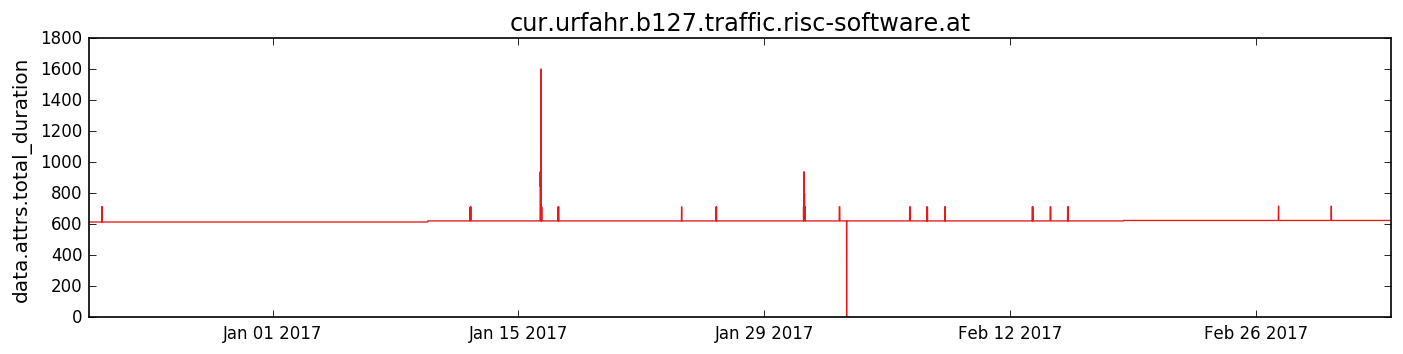

--  data.attrs.total_duration   cur.rohrbach.b127.traffic.risc-software.at


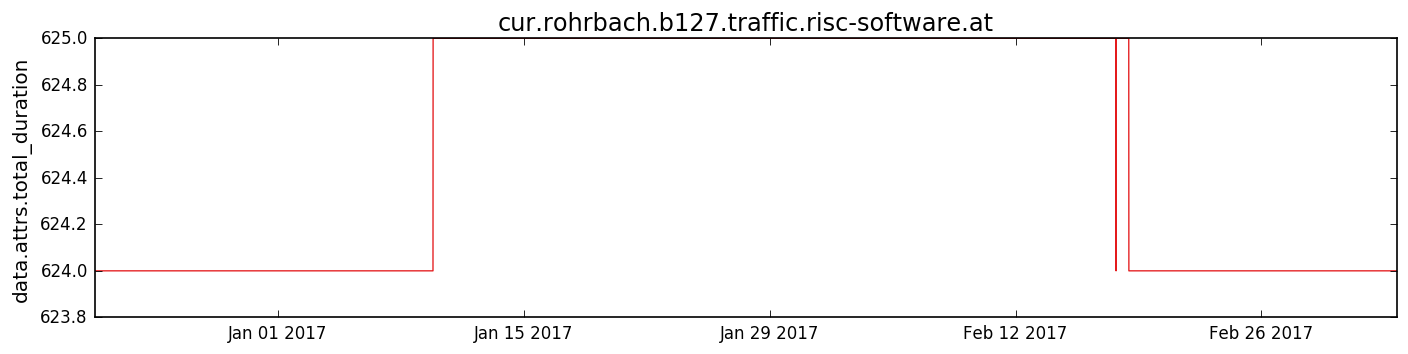

--  data.attrs.total_duration   cur.franzosenhausweg.knotenlinz.traffic.risc-software.at


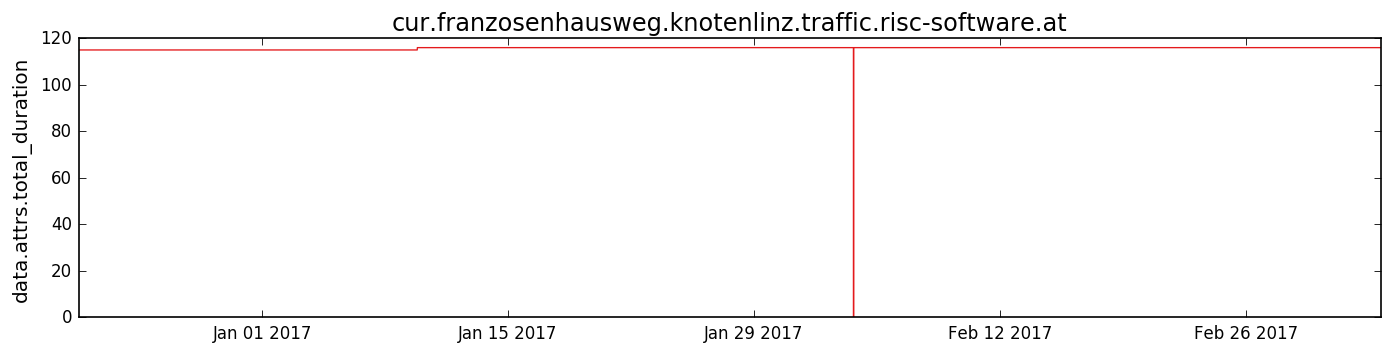

--  data.attrs.total_duration   cur.zentrum.b129.traffic.risc-software.at


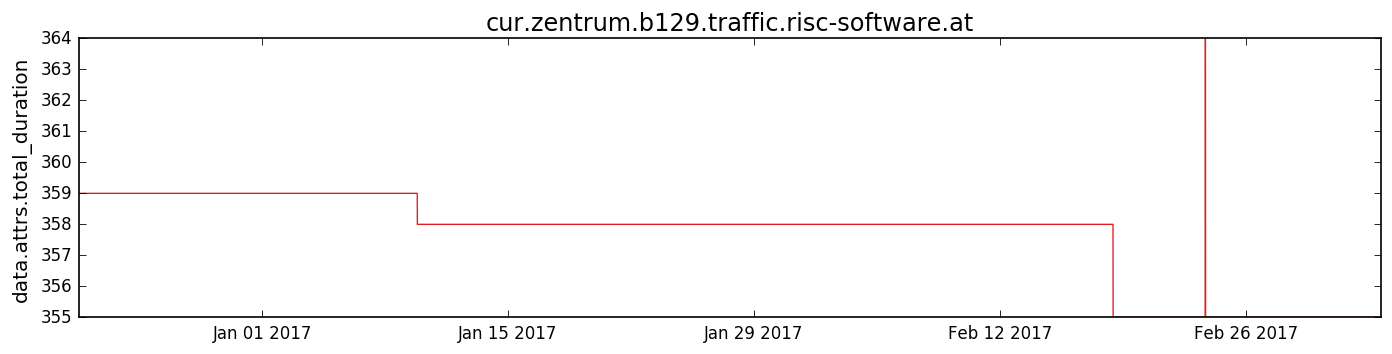

--  data.attrs.total_duration   cur.florianerstrasse.knotenlinz.traffic.risc-software.at


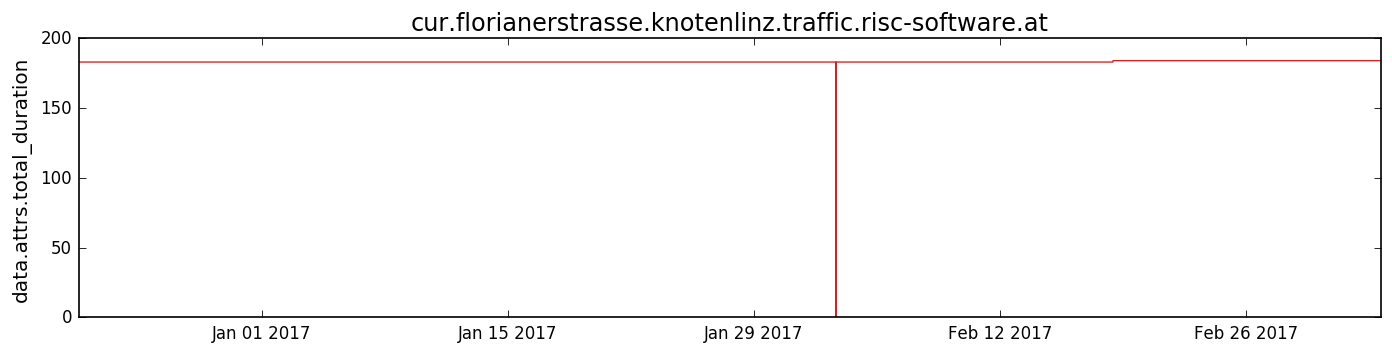

--  data.attrs.total_duration   cur.linz.steyreggerbruecke.traffic.risc-software.at


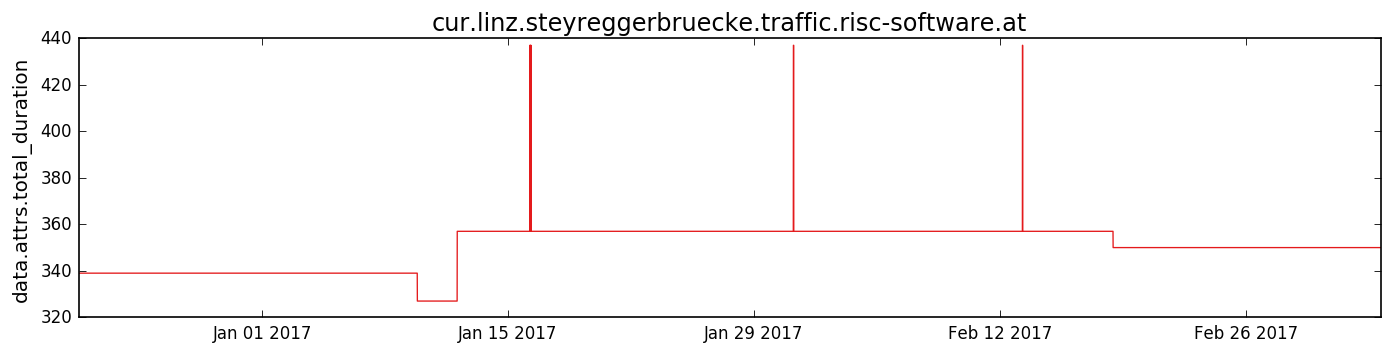

--  data.attrs.total_duration   cur.zentrum.nibelungenbruecke.traffic.risc-software.at


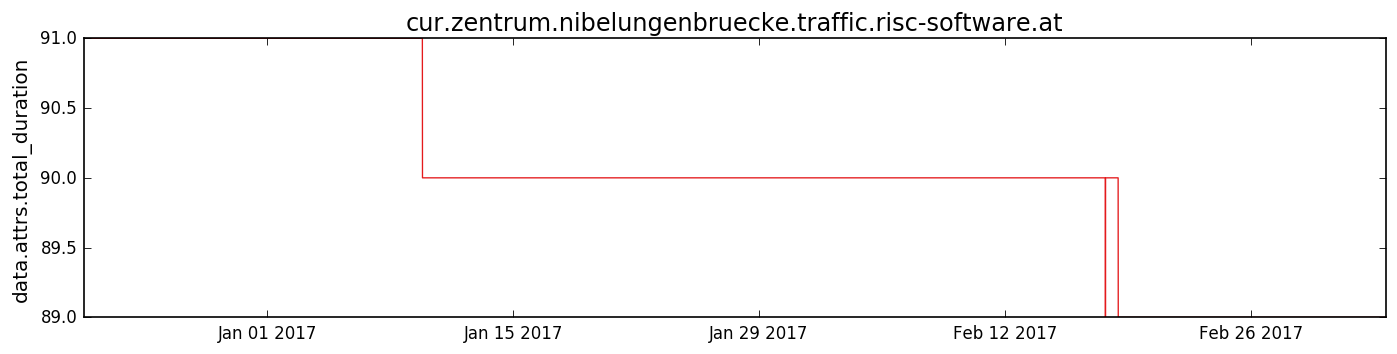

--  data.attrs.total_duration   cur.einwaerts.bindermichl.traffic.risc-software.at


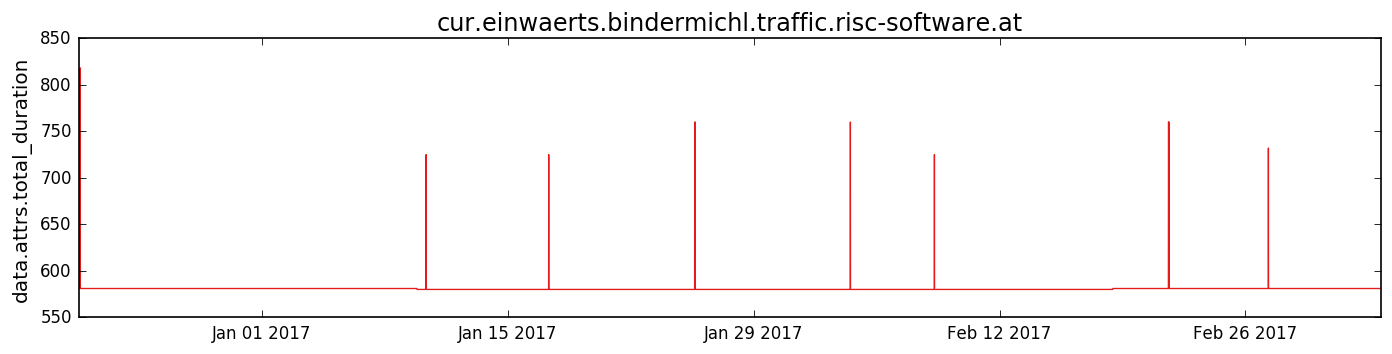

--  data.attrs.total_duration   cur.traun.b1.traffic.risc-software.at


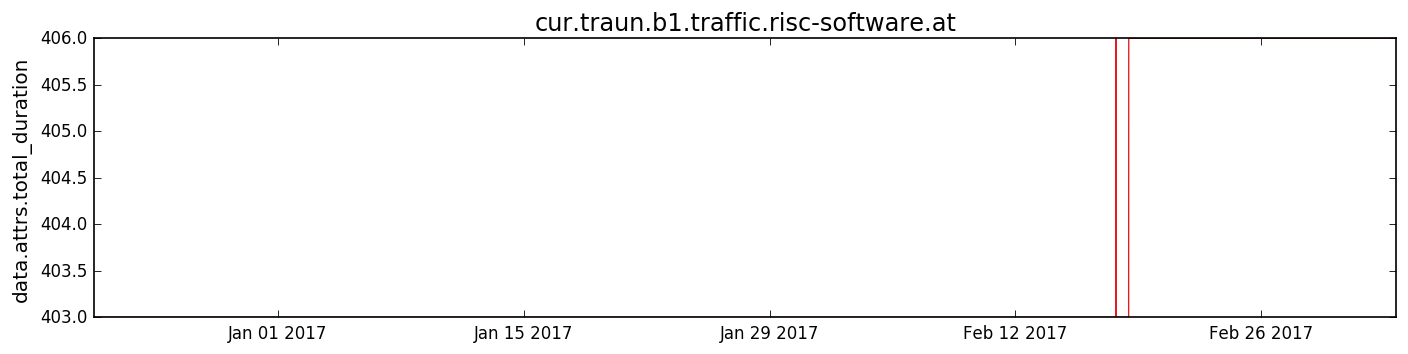

--  data.attrs.total_duration   cur.auswaerts.haselgraben.traffic.risc-software.at


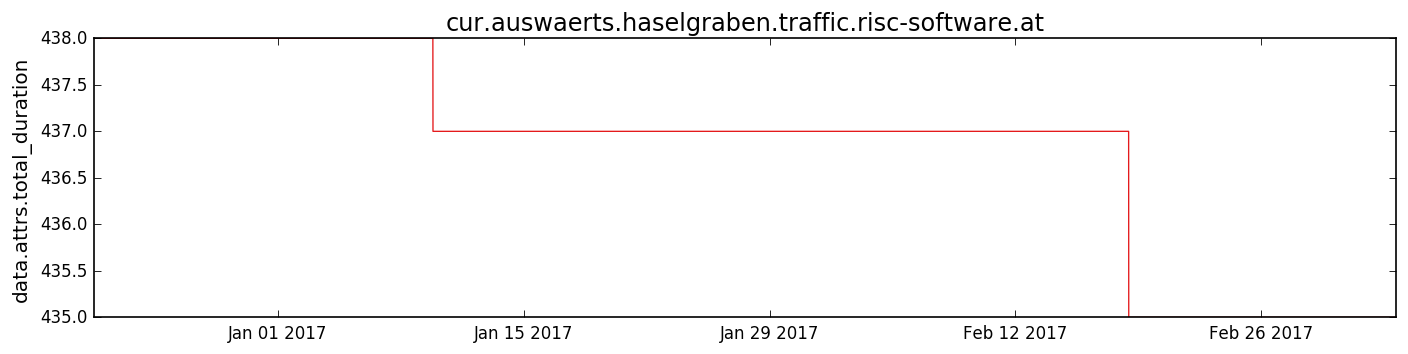

--  data.attrs.total_duration   cur.einwaerts.haselgraben.traffic.risc-software.at


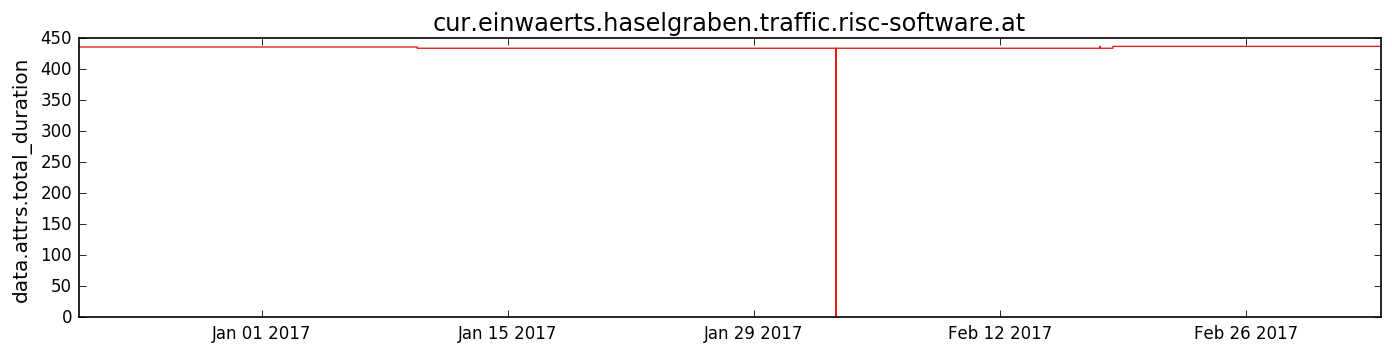

--  data.attrs.total_duration_in_traffic   cur.wilhering.b129.traffic.risc-software.at


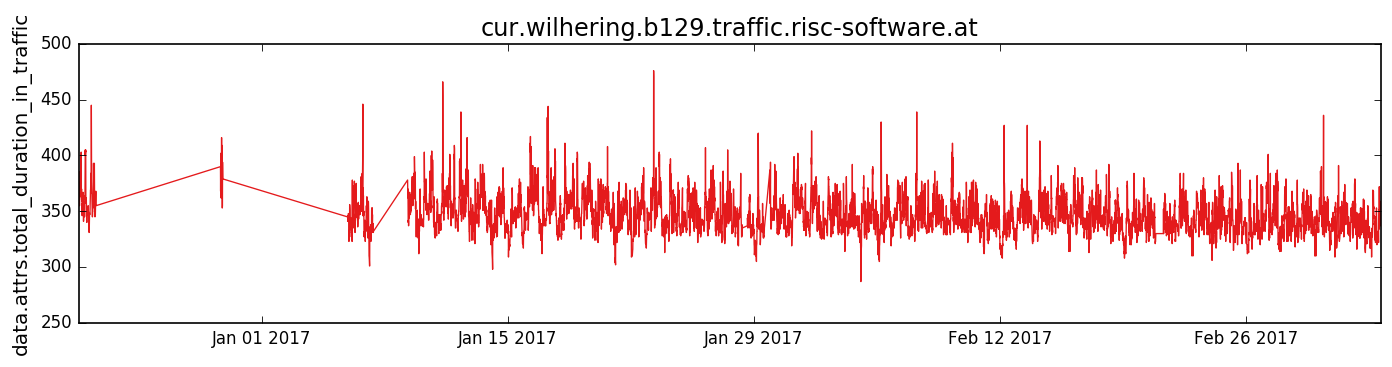

--  data.attrs.total_duration_in_traffic   cur.auswaerts.bindermichl.traffic.risc-software.at


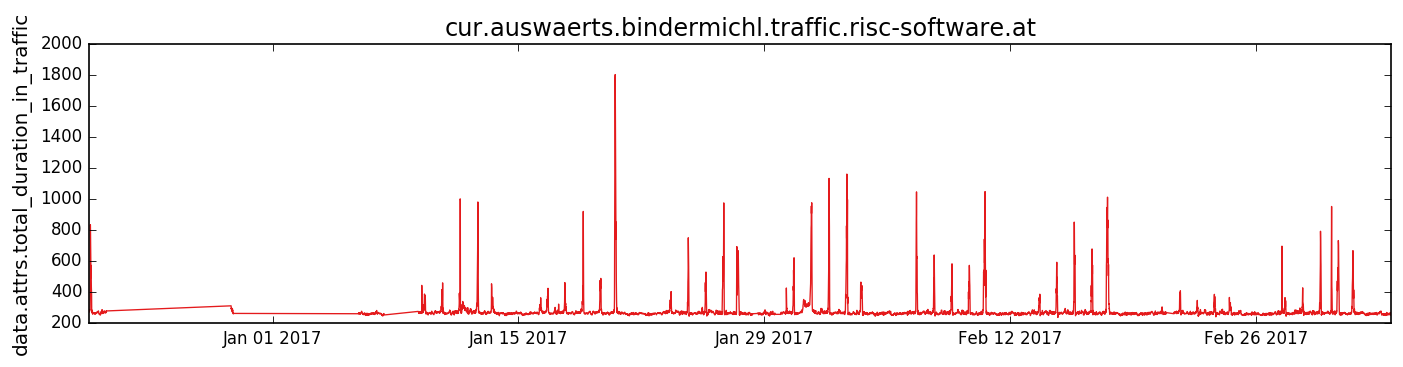

--  data.attrs.total_duration_in_traffic   cur.steyregg.steyreggerbruecke.traffic.risc-software.at


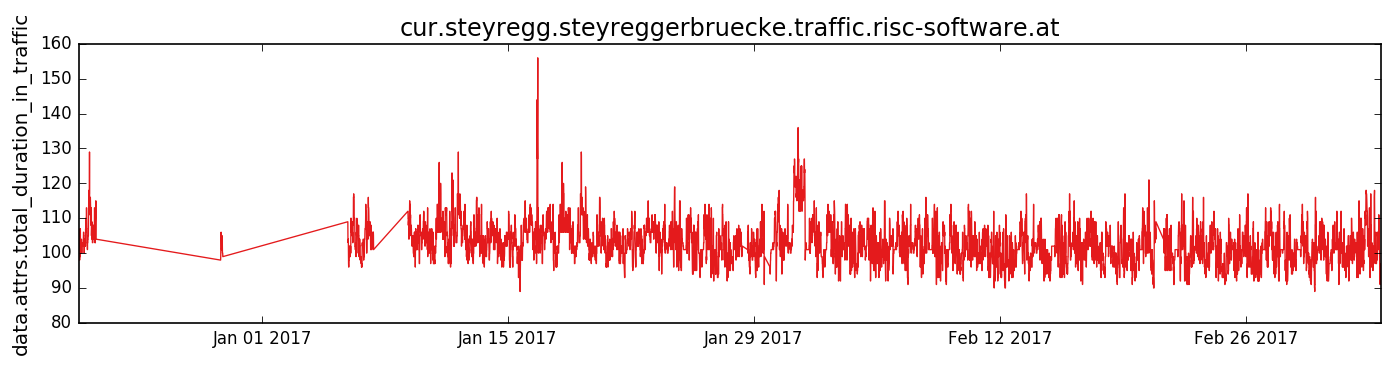

--  data.attrs.total_duration_in_traffic   cur.haid.knotenlinz.traffic.risc-software.at


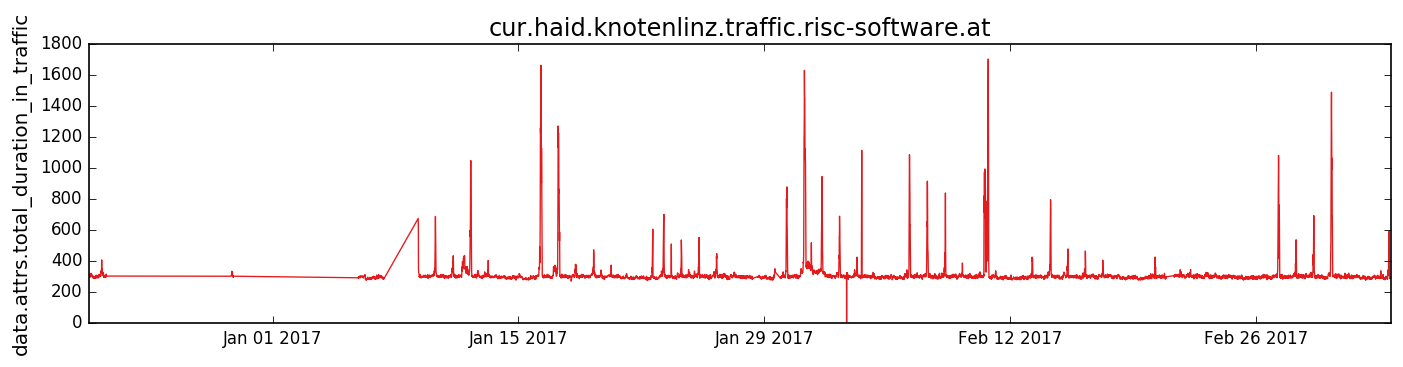

--  data.attrs.total_duration_in_traffic   cur.bindermichl.b1.traffic.risc-software.at


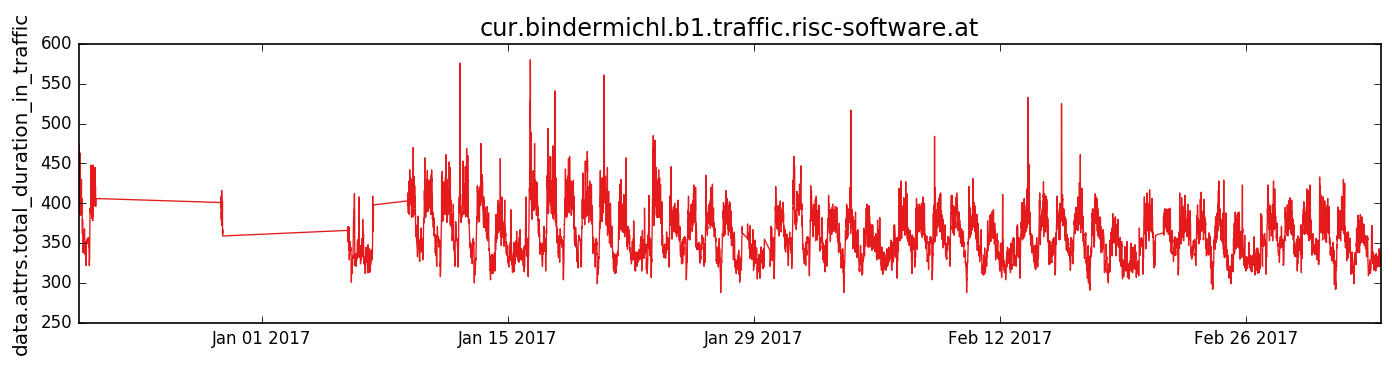

--  data.attrs.total_duration_in_traffic   cur.urfahr.autobahnbruecke.traffic.risc-software.at


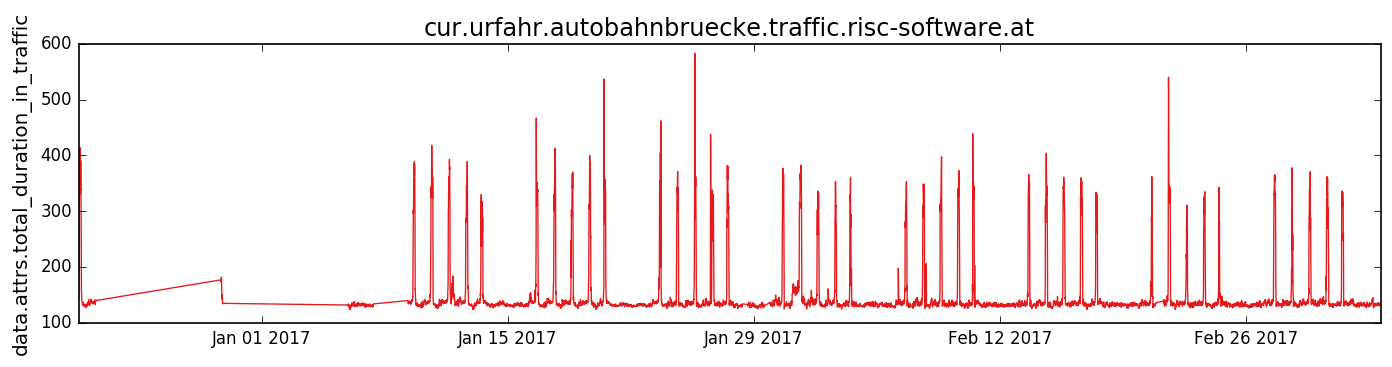

--  data.attrs.total_duration_in_traffic   cur.linz.autobahnbruecke.traffic.risc-software.at


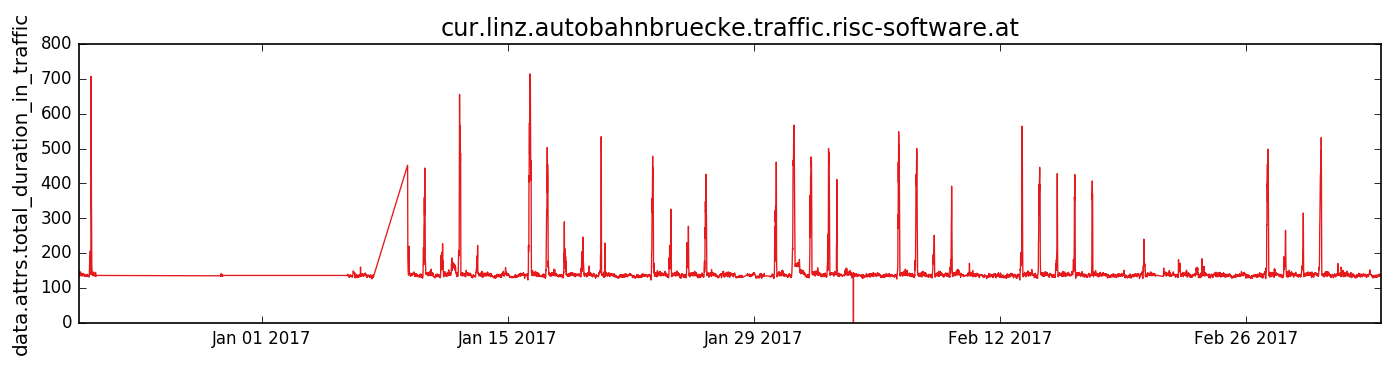

--  data.attrs.total_duration_in_traffic   cur.urfahr.nibelungenbruecke.traffic.risc-software.at


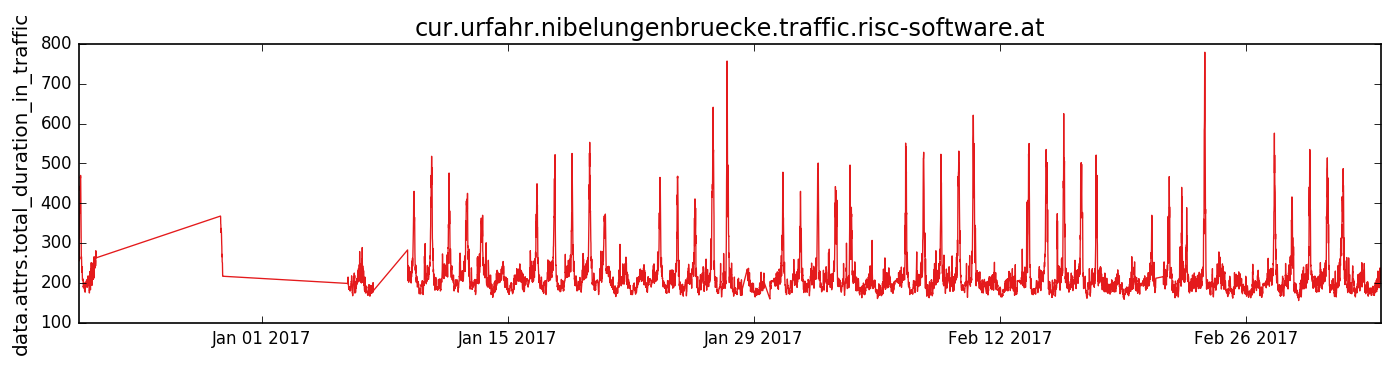

--  data.attrs.total_duration_in_traffic   cur.urfahr.b127.traffic.risc-software.at


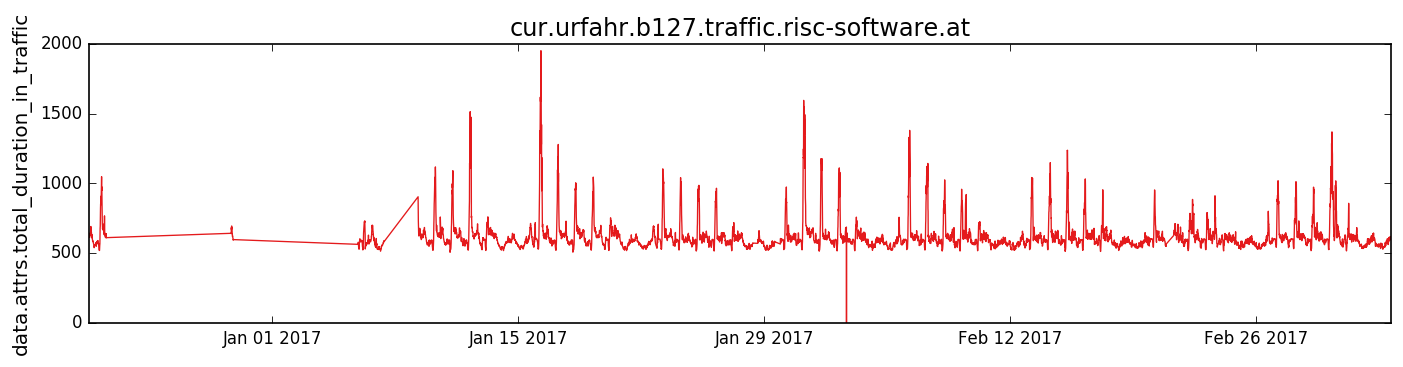

--  data.attrs.total_duration_in_traffic   cur.rohrbach.b127.traffic.risc-software.at


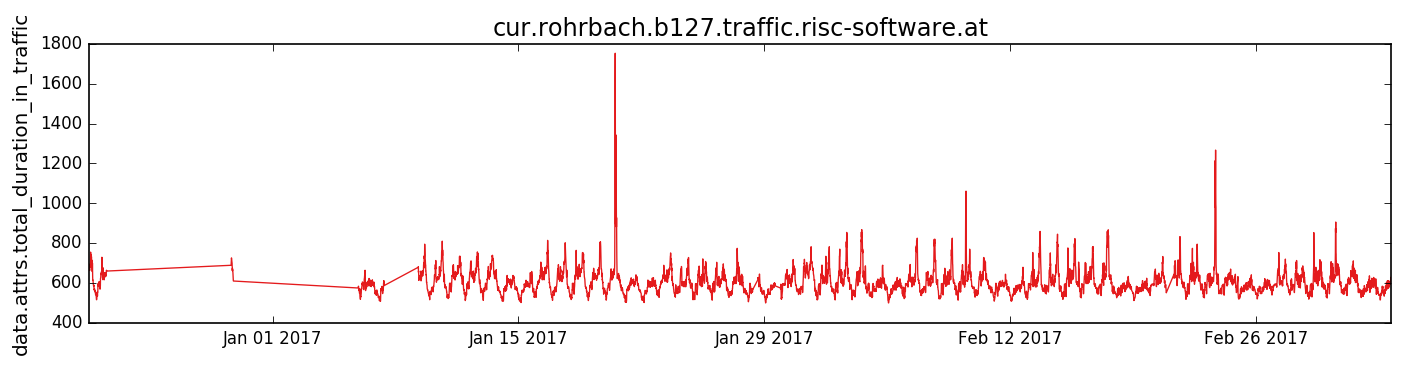

--  data.attrs.total_duration_in_traffic   cur.franzosenhausweg.knotenlinz.traffic.risc-software.at


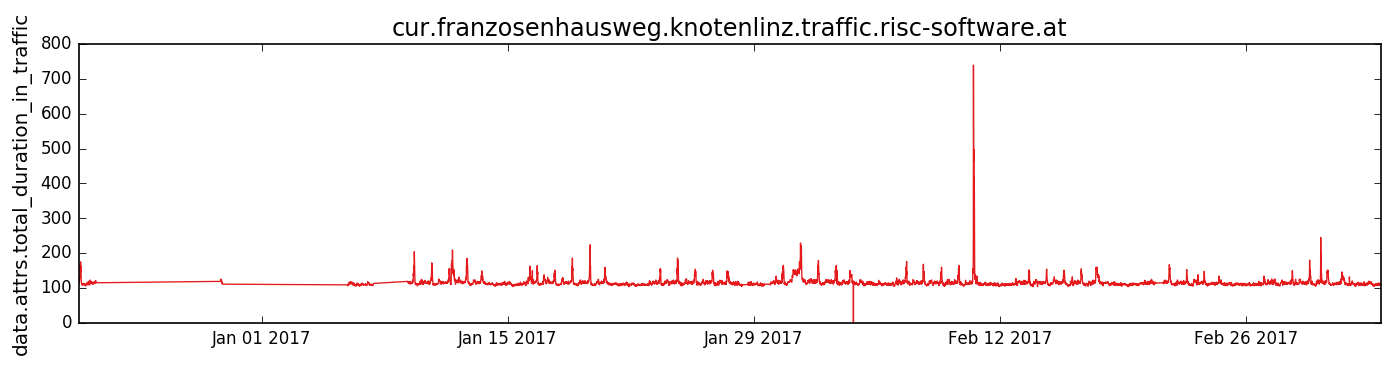

--  data.attrs.total_duration_in_traffic   cur.zentrum.b129.traffic.risc-software.at


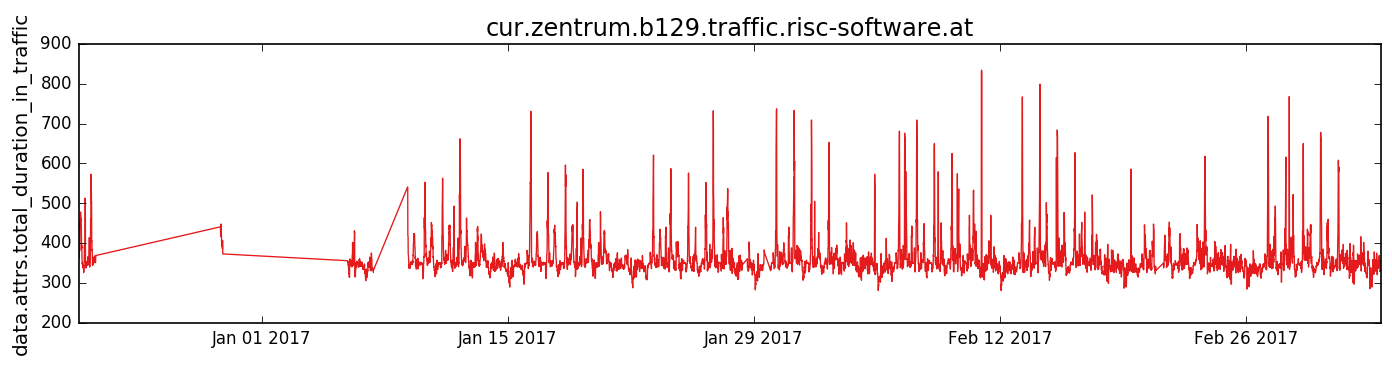

--  data.attrs.total_duration_in_traffic   cur.florianerstrasse.knotenlinz.traffic.risc-software.at


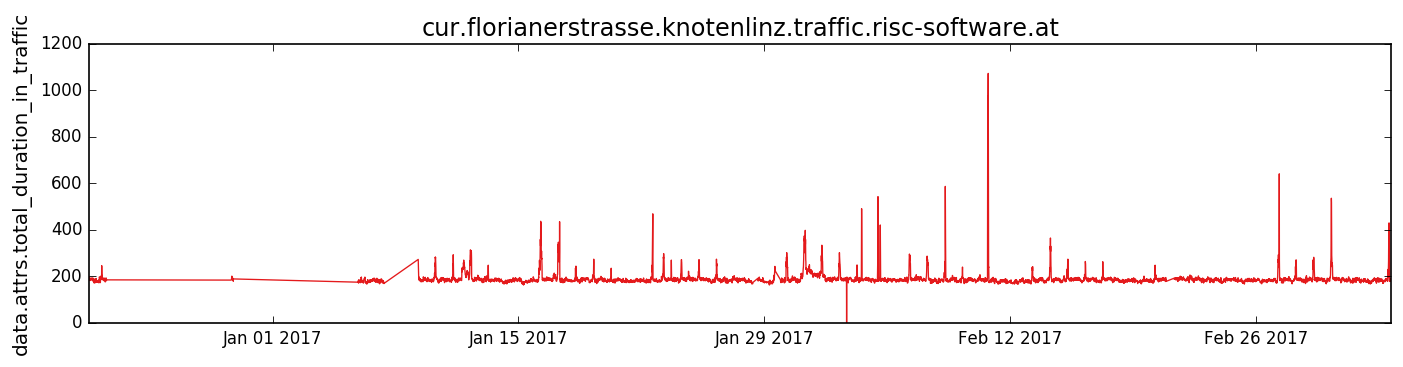

--  data.attrs.total_duration_in_traffic   cur.linz.steyreggerbruecke.traffic.risc-software.at


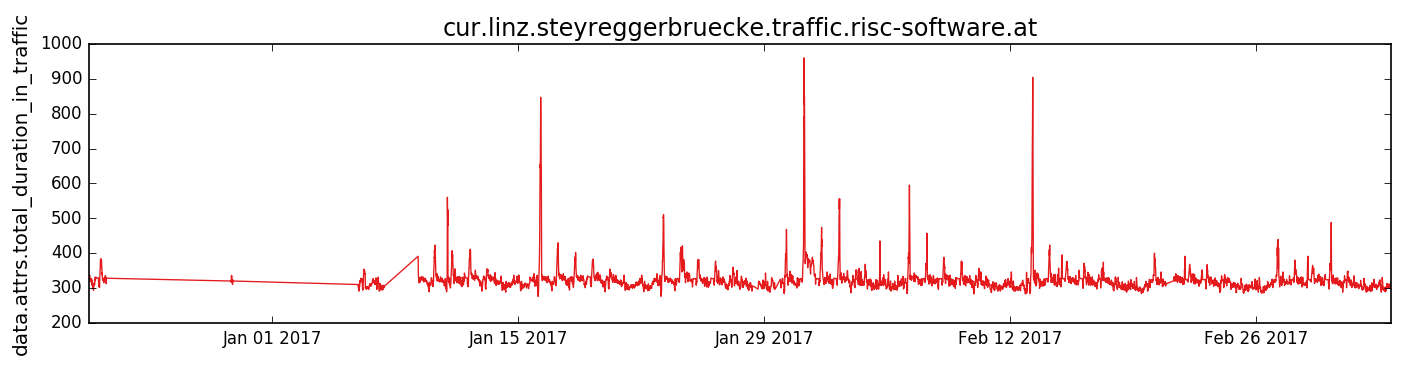

--  data.attrs.total_duration_in_traffic   cur.zentrum.nibelungenbruecke.traffic.risc-software.at


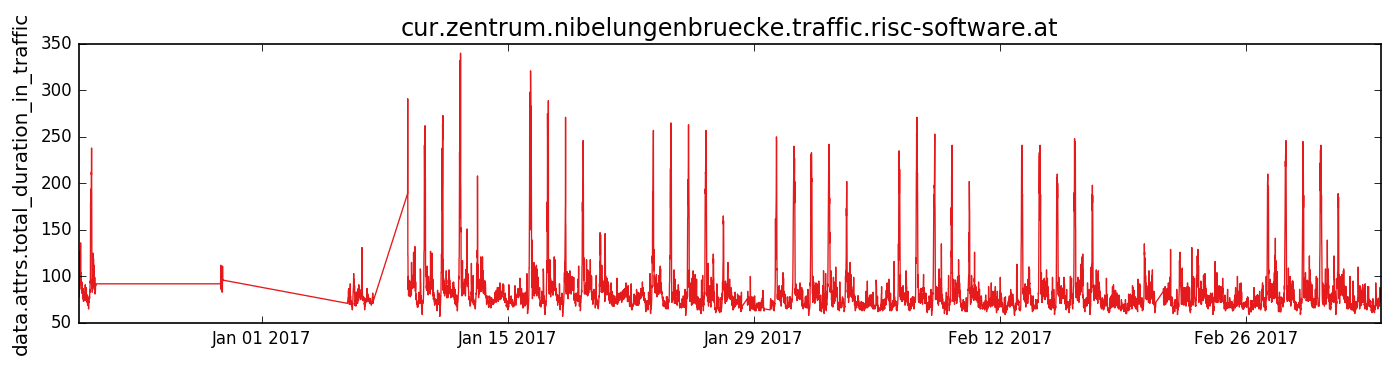

--  data.attrs.total_duration_in_traffic   cur.einwaerts.bindermichl.traffic.risc-software.at


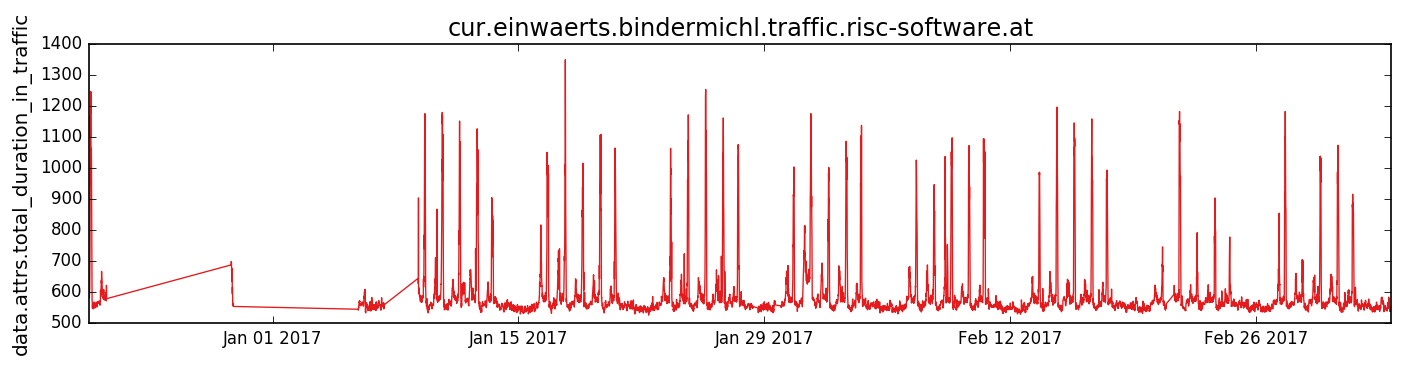

--  data.attrs.total_duration_in_traffic   cur.traun.b1.traffic.risc-software.at


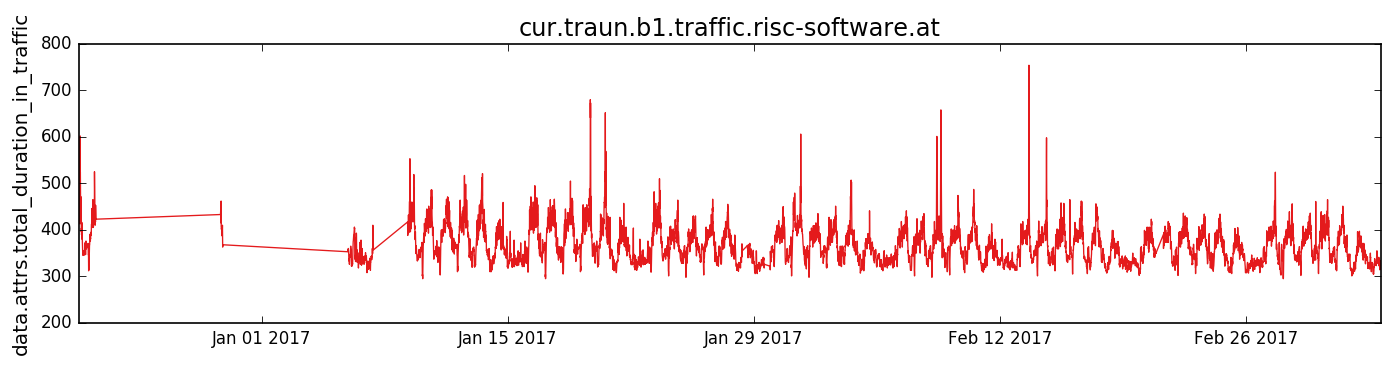

--  data.attrs.total_duration_in_traffic   cur.auswaerts.haselgraben.traffic.risc-software.at


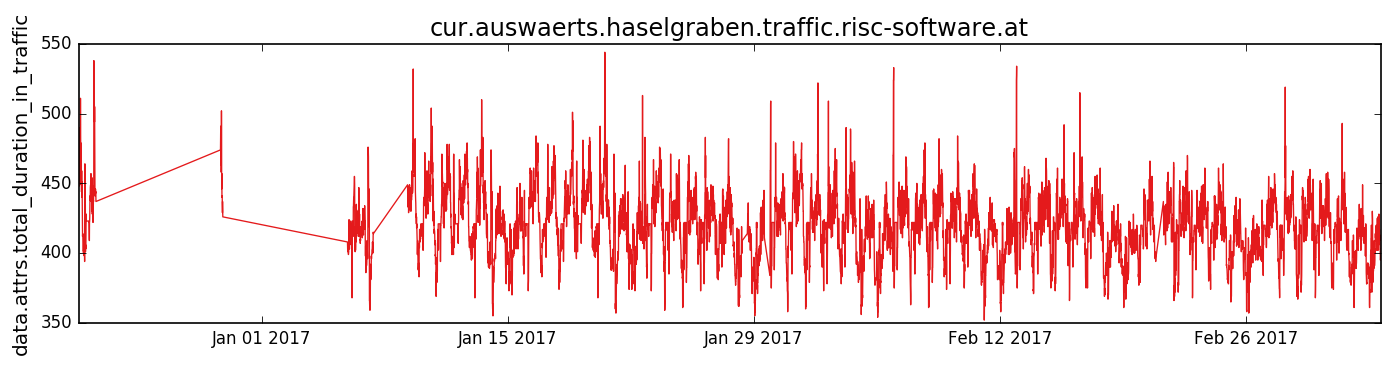

--  data.attrs.total_duration_in_traffic   cur.einwaerts.haselgraben.traffic.risc-software.at


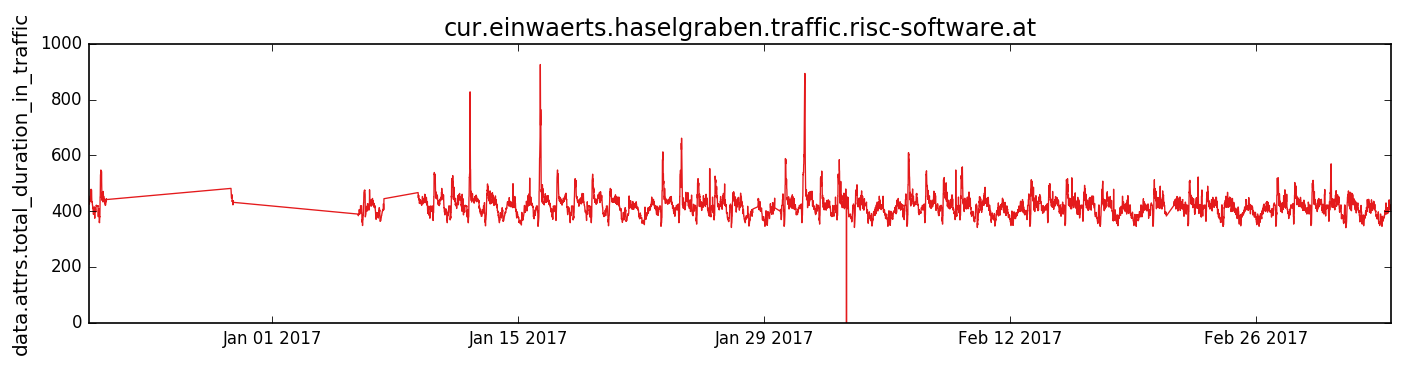

In [14]:
for f in features :
    for c in cur_df:
        print '-- ', f, ' ', c
        if str(cur_df[c][f].dtype) == "object": continue
        plt.figure(figsize=(14,3))
        plt.title(c)
        plt.plot(cur_df[c]["date"], cur_df[c][f], lw=0.8)
        plt.ylabel(f)
        plt.show()

In [15]:
train_data = cur_df['cur.zentrum.nibelungenbruecke.traffic.risc-software.at']

--  data.attrs.delay   cur.einwaerts.haselgraben.traffic.risc-software.at


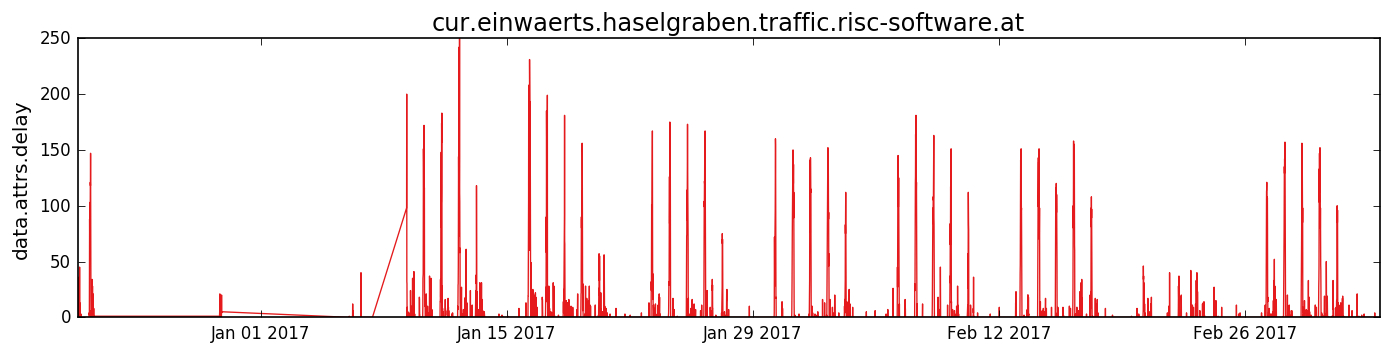

--  data.attrs.delayed_average_speed   cur.einwaerts.haselgraben.traffic.risc-software.at


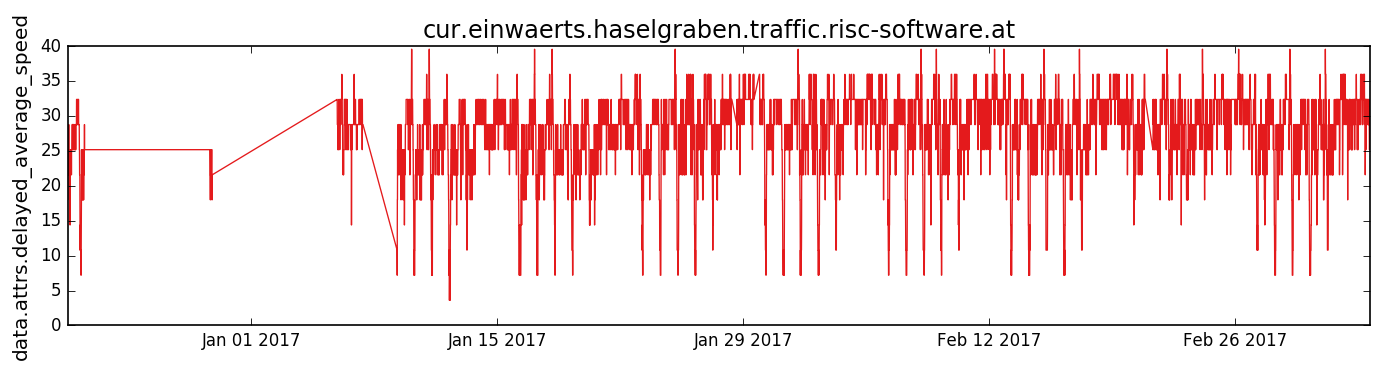

--  data.attrs.duration   cur.einwaerts.haselgraben.traffic.risc-software.at


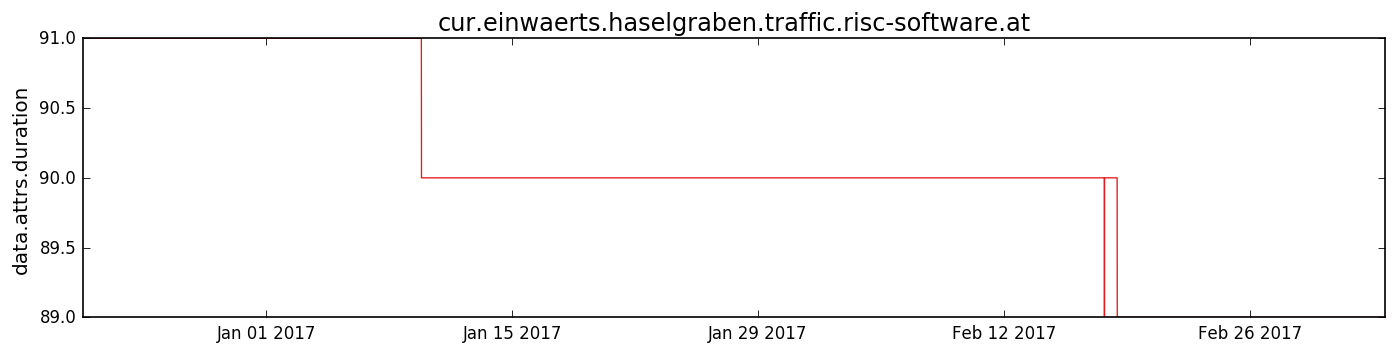

--  data.attrs.duration_in_traffic   cur.einwaerts.haselgraben.traffic.risc-software.at


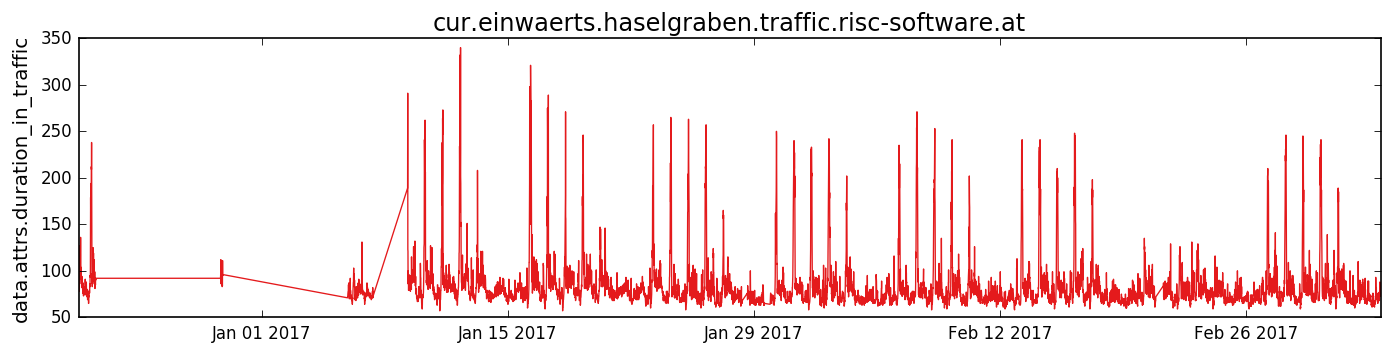

--  data.attrs.total_duration   cur.einwaerts.haselgraben.traffic.risc-software.at


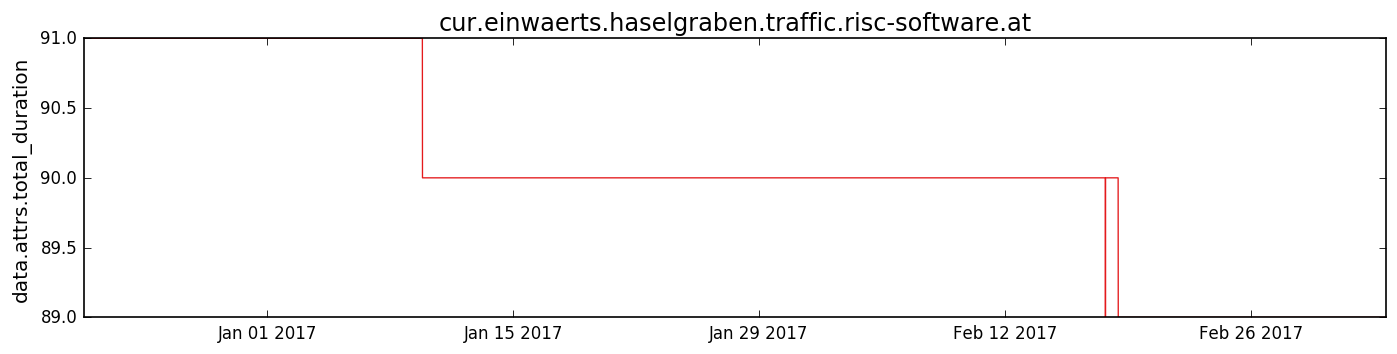

--  data.attrs.total_duration_in_traffic   cur.einwaerts.haselgraben.traffic.risc-software.at


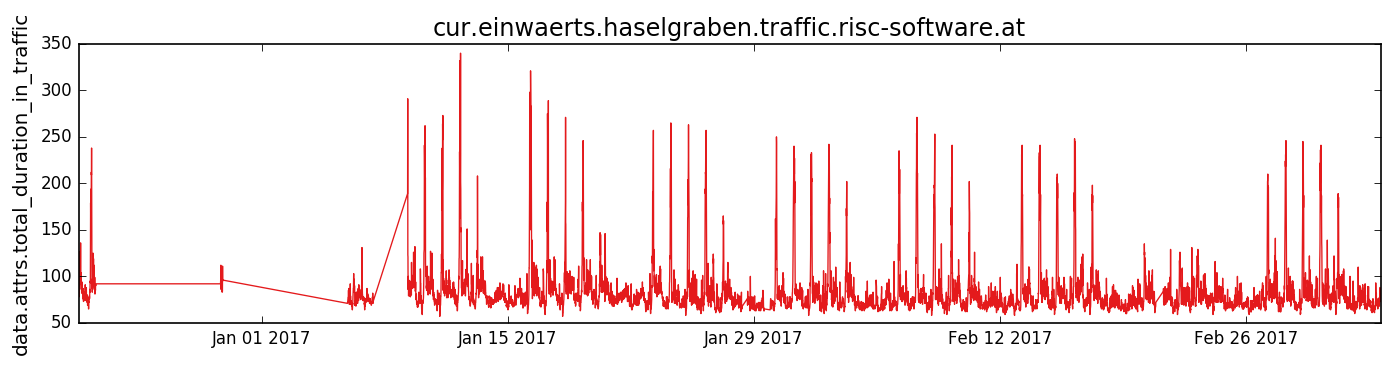

In [16]:
from itertools import chain


for f in features :
    print '-- ', f, ' ', c
    if str(train_data[f].dtype) == "object": 
        train_data[f] = pd.Series(list(chain(*train_data[f].values)))
    plt.figure(figsize=(14,3))
    plt.title(c)
    plt.plot(train_data["date"], train_data[f], lw=0.8)
    plt.ylabel(f)
    plt.show()

In [17]:
train_data["date"]
train_serie = pd.Series(train_data['data.attrs.delay'].values, 
                        index=train_data["date"])
train_serie.between_time(start_time='01:00', end_time='02:00')

date
2016-12-22 01:02:03     0
2016-12-22 01:12:03     0
2016-12-22 01:22:03     0
2016-12-22 01:32:04     0
2016-12-22 01:42:04     0
2016-12-22 01:52:04     0
2017-01-06 01:00:00     0
2017-01-06 01:10:00     0
2017-01-06 01:20:00     0
2017-01-06 01:30:00     0
2017-01-06 01:40:00     0
2017-01-06 01:50:00     0
2017-01-06 02:00:00     0
2017-01-07 01:00:00     0
2017-01-07 01:10:00     0
2017-01-07 01:20:00     0
2017-01-07 01:30:00     0
2017-01-07 01:40:00     0
2017-01-07 01:50:00     0
2017-01-07 02:00:00     0
2017-01-10 01:00:00     2
2017-01-10 01:10:00     0
2017-01-10 01:20:00     0
2017-01-10 01:30:00     0
2017-01-10 01:40:00     0
2017-01-10 01:50:00     0
2017-01-10 02:00:00     0
2017-01-11 01:00:00     0
2017-01-11 01:10:00     0
2017-01-11 01:20:00     0
                       ..
2017-03-01 01:50:00     0
2017-03-01 02:00:00     0
2017-03-02 01:00:00     0
2017-03-02 01:10:00     0
2017-03-02 01:20:00     0
2017-03-02 01:30:00     0
2017-03-02 01:40:00     0
2017-03

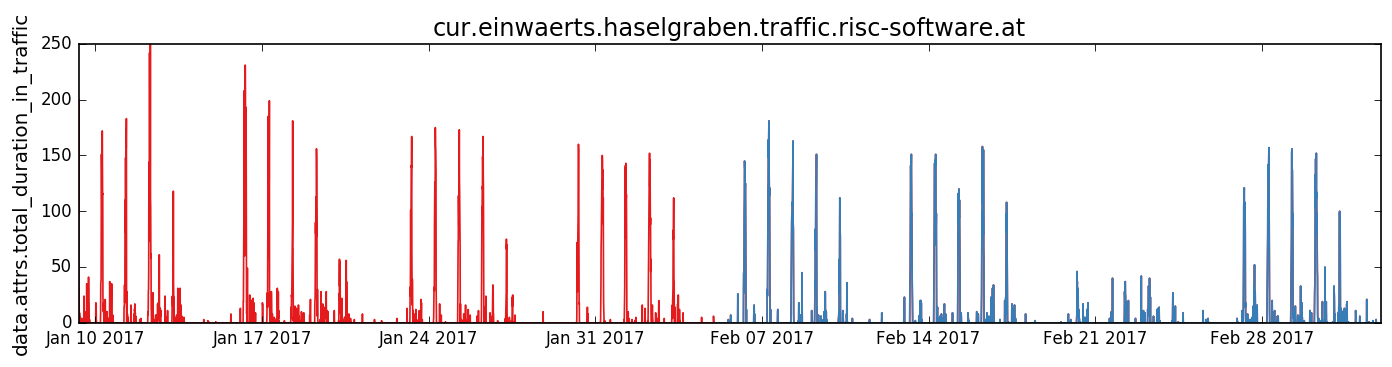

In [18]:
plt.figure(figsize=(14,3))
plt.title(c)
plt.plot(train_serie.loc['2017-01-08':'2017-03-04'],lw=1)
plt.plot(train_serie.loc['2017-02-05':'2017-03-04'],lw=1)
plt.ylabel(f)
plt.show()

In [30]:
def get_precip(gooddate):
    urlstart = 'http://api.wunderground.com/api/0af2503015c7c8fd/history_'
    urlend = '/q/Austria/Linz.json'

    url = urlstart + str(gooddate) + urlend
    data = requests.get(url).json()
    for summary in data['history']['dailysummary']:
        print ','.join((gooddate,summary['date']['year'],
                        summary['date']['mon'],
                        summary['date']['mday'],
                        summary['precipm'], 
                        summary['maxtempm'], 
                        summary['meantempm'],
                        summary['mintempm']))

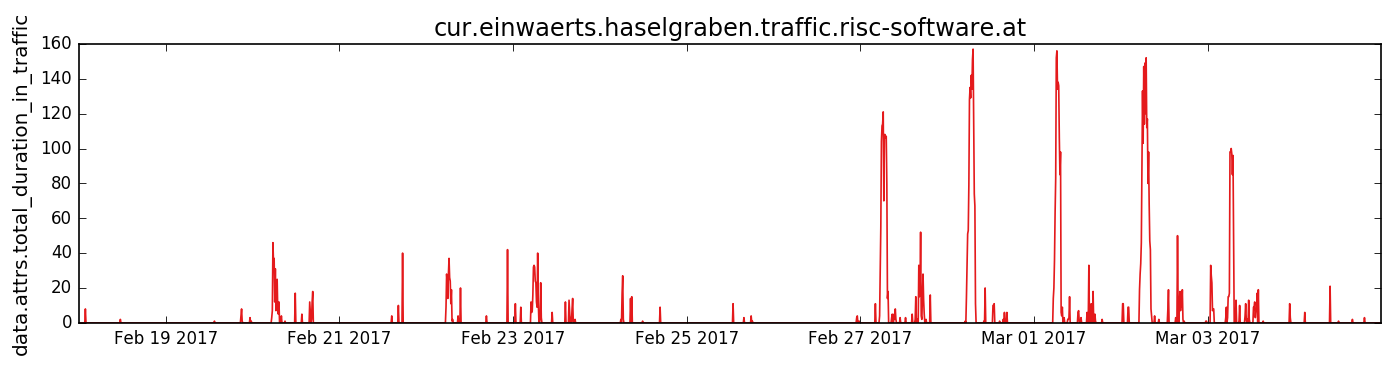

In [19]:
plt.figure(figsize=(14,3))
plt.title(c)
plt.plot(train_serie.loc['2017-02-18':'2017-03-04'],lw=1)
plt.ylabel(f)
plt.show()

In [20]:
ewma = pd.stats.moments.ewma
EMOV_n = ewma( train_data['data.attrs.delay'] , com=5 )

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,com=5).mean()
  from ipykernel import kernelapp as app


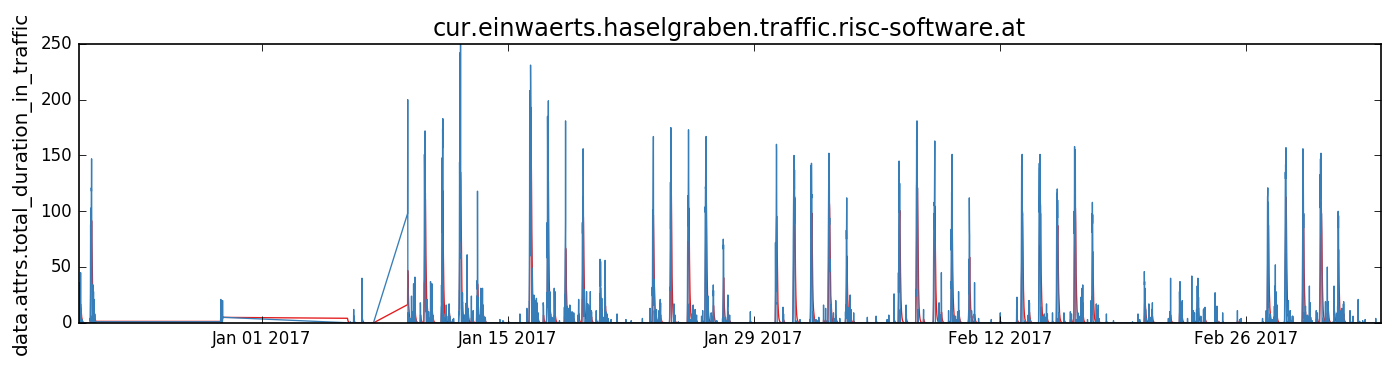

In [21]:
plt.figure(figsize=(14,3))
plt.title(c)
plt.plot(train_data["date"], EMOV_n       , lw=0.8)
plt.plot(train_data["date"], train_data['data.attrs.delay'], lw=0.8)
plt.ylabel(f)
plt.show()

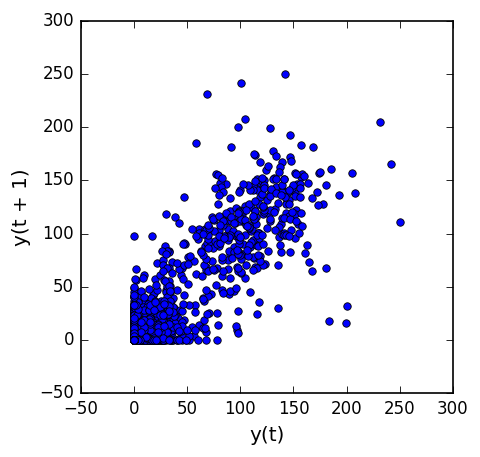

In [22]:
from pandas.tools.plotting import lag_plot
plt.figure(figsize=(4,4))
lag_plot(train_data['data.attrs.delay'])
plt.show()

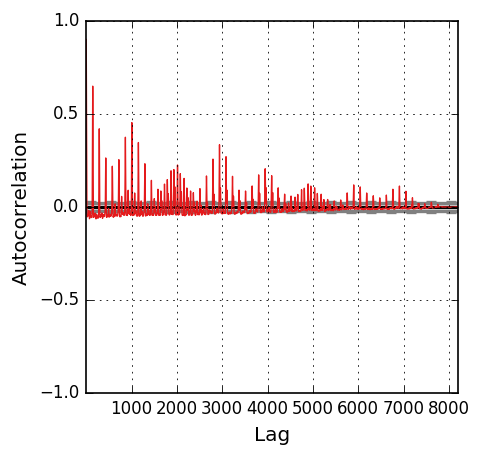

In [23]:
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(4,4))
autocorrelation_plot(train_data['data.attrs.delay'], lw=0.8)
plt.show()

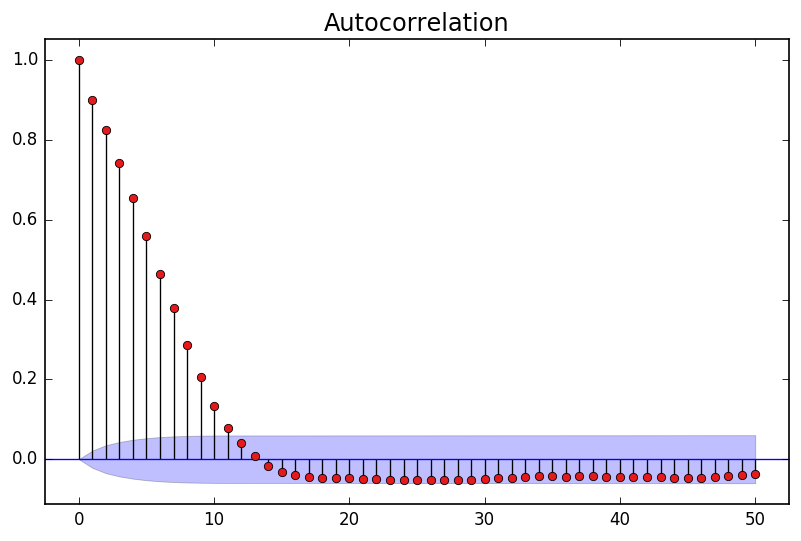

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(4,4))
plot_acf(train_data['data.attrs.delay'], lw=0.8, lags=50)
plt.show()

In [25]:
values = pd.DataFrame(train_data['data.attrs.delay'].values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.900707
t+1  0.900707  1.000000


In [26]:
import numpy as np

def organize_data(to_forecast, window, horizon):
    """
     Input:
      to_forecast, univariate time series organized as numpy array
      window, number of items to use in the forecast window
      horizon, horizon of the forecast
     Output:
      X, a matrix where each row contains a forecast window
      y, the target values for each row of X
    """
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast, 
                                        shape=shape, 
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

k = 4   # number of previous observations to use
h = 1   # forecast horizon
X,y = organize_data(train_data['data.attrs.delay'].values, k, h)

In [27]:
from sklearn.linear_model import LinearRegression
 
m = 100 # number of samples to take in account
regressor = LinearRegression(normalize=True)
regressor.fit(X[:m], y[:m])

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [28]:
def mape(ypred, ytrue):
    """ returns the mean absolute percentage error """
    idx = ytrue != 0.0
    return 100*np.mean(np.abs(ypred[idx]-ytrue[idx])/ytrue[idx])

print 'The error is %0.2f%%' % mape(regressor.predict(X[m:]),y[m:])

The error is 119.58%


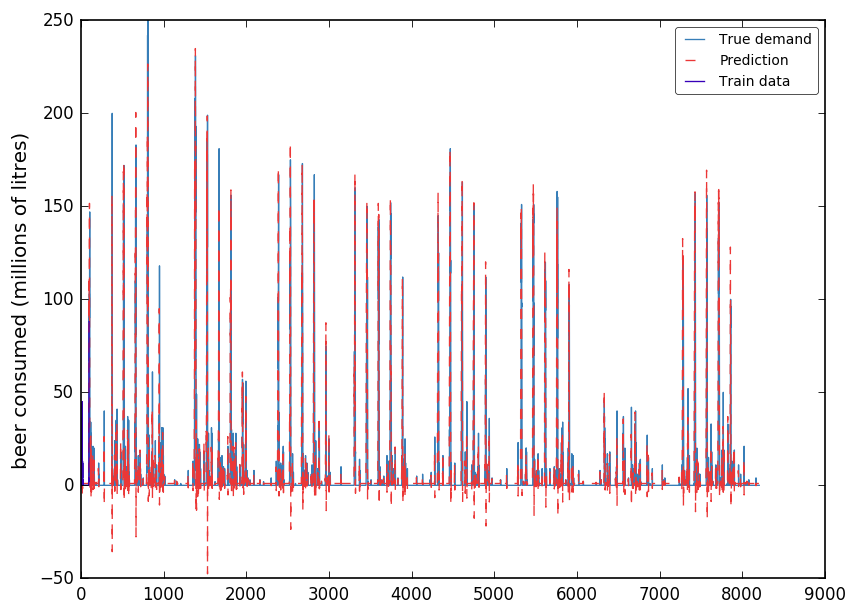

In [29]:
plt.figure(figsize=(8,6))
plt.plot(train_data['data.attrs.delay'].values, label='True demand', color='#377EB8', linewidth=0.8)
plt.plot(regressor.predict(X),'--', color='#EB3737', linewidth=0.8, label='Prediction')
plt.plot(train_data['data.attrs.delay'].values[:m], label='Train data', color='#3700B8', linewidth=0.8)
plt.legend(loc='upper right')
plt.ylabel('beer consumed (millions of litres)')
plt.show()